
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## COMPSCI 109A - Group Project Notebook

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">

#### Submitted by:  Ben Horev, Katrine Pertsovski, Parth Patel

### Import libraries and data

In [1]:
#Below is the list of libraries that were used
import csv
import numpy as np
import pandas as pd 
import math

#Plotting
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

#NLTK toolkit
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')

#Sklearn 
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer

from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.api import OLS
import datetime
from datetime import timedelta


import tensorflow as tf

print(tf.__version__)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Yoyo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yoyo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2.0.0


### Get Trump tweets data; convert dates to datetime and remove retweets

In [2]:
tweets = pd.read_csv('tweets.csv') #president tweets 
tweets = tweets.rename(columns={'created_at':'Date'})
tweets['text'] = tweets['text'].apply(str) #convert to string for NLTK
tweets['hour'] = pd.to_datetime(tweets['Date'], errors='coerce').dt.hour
tweets['Date'] = pd.to_datetime(tweets['Date'], errors='coerce').dt.date #convert dates from str to regular dates
tweets = tweets[tweets['is_retweet'] == 'false'].reset_index(drop=True) #remove retweets
display(tweets.head())


,source,text,Date,retweet_count,favorite_count,is_retweet,id_str,hour
0,Twitter for iPhone,“Serial killers get more Due Process than the ...,2019-10-14,19867.0,74617,false,1.183541e+18,0.0
1,Twitter for iPhone,Somebody please explain to Chris Wallace of Fo...,2019-10-14,26122.0,106477,false,1.183535e+18,0.0
2,Twitter for iPhone,The U.S. has the worst of the ISIS prisoners. ...,2019-10-13,16861.0,67151,false,1.183525e+18,23.0
3,Twitter for iPhone,.@marklevinshow on @FoxNews is doing a big sho...,2019-10-13,14569.0,50631,false,1.183520e+18,23.0
4,Twitter for iPhone,.....BY THE WAY DON’T CALL ME AGAIN I’LL CALL ...,2019-10-13,18997.0,71535,false,1.183507e+18,22.0


### Import financial indicator data

In [3]:
#CBOE = pd.read_csv('^VIX.csv') #SNP500 volatility index
CBOE = pd.read_csv('^GSPC.csv') #SNP500 index
#CBOE = pd.read_csv('GOVT.csv') #SNP500 volatility index
CBOE['Date'] = pd.to_datetime(CBOE['Date']).dt.date #convert dates from str to date
CBOE.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-01,2128.679932,2131.449951,2097.850098,2111.719971,2111.719971,4532160000
1,2016-11-02,2109.429932,2111.760010,2094.000000,2097.939941,2097.939941,4248580000
2,2016-11-03,2098.800049,2102.560059,2085.229980,2088.659912,2088.659912,3886740000
3,2016-11-04,2083.790039,2099.070068,2083.790039,2085.179932,2085.179932,3837860000
4,2016-11-07,2100.590088,2132.000000,2100.590088,2131.520020,2131.520020,3736060000


In [4]:
CBOE['Date'] = CBOE['Date']-timedelta(days=1)

In [5]:
CBOE.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-10-31,2128.679932,2131.449951,2097.850098,2111.719971,2111.719971,4532160000
1,2016-11-01,2109.429932,2111.760010,2094.000000,2097.939941,2097.939941,4248580000
2,2016-11-02,2098.800049,2102.560059,2085.229980,2088.659912,2088.659912,3886740000
3,2016-11-03,2083.790039,2099.070068,2083.790039,2085.179932,2085.179932,3837860000
4,2016-11-06,2100.590088,2132.000000,2100.590088,2131.520020,2131.520020,3736060000


### Create response variables adjusted for time series trend

In [6]:
#moving average
CBOE['moving_avg'] = CBOE['Close'].rolling(window=28, center = True).mean()
#daily change vs moving average
CBOE['daily_change_close'] = (CBOE['Close']-CBOE['Close'].rolling(window=28).mean())/CBOE['Close'].rolling(window=28).mean()*100
#daily high or low vs moving avarege
CBOE['daily_change_high'] = (CBOE['High']-CBOE['Close'].rolling(window=28).mean())/CBOE['Close'].rolling(window=28).mean()*100
CBOE['daily_change_low'] = (CBOE['Low']-CBOE['Close'].rolling(window=28).mean())/CBOE['Close'].rolling(window=28).mean()*100
#daily range vs. the opening price
CBOE['daily_change_low_high'] = (CBOE['High']-CBOE['Low'])/CBOE['Open']*100

CBOE = CBOE.dropna()
CBOE.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,moving_avg,daily_change_close,daily_change_high,daily_change_low,daily_change_low_high
724,2019-09-18,3010.360107,3021.989990,3003.159912,3006.790039,3006.790039,3251290000,2964.875366,2.442608,2.960477,2.318928,0.625509
725,2019-09-19,3008.419922,3016.370117,2984.679932,2992.070068,2992.070068,6094740000,2964.690360,1.805608,2.632420,1.554157,1.053383
726,2019-09-22,2983.500000,2999.149902,2982.229980,2991.780029,2991.780029,3186590000,2965.107143,1.714829,1.965391,1.390146,0.567117
727,2019-09-23,3002.429932,3007.979980,2957.729980,2966.600098,2966.600098,3868160000,2967.392857,0.704690,2.109378,0.403583,1.673644
728,2019-09-24,2968.350098,2989.820068,2952.860107,2984.870117,2984.870117,3318870000,2968.406067,1.156541,1.324294,0.071729,1.245135


### Plot response variables and change in response variables

C:\Users\Yoyo\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


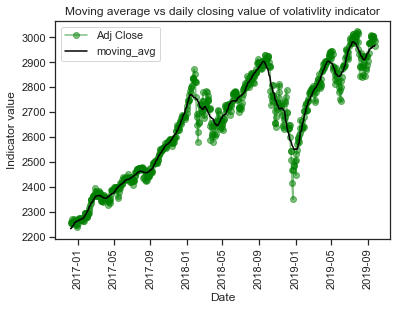

In [7]:
#plot variables    
x = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['Date']
y1 = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['moving_avg']
y2 = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['Adj Close']  
#plot
plt.ylabel("Indicator value")
plt.xlabel("Date")
plt.title('Moving average vs daily closing value of volativlity indicator')
plt.plot(x, y2, marker = 'o' , label = 'Adj Close', color='green', alpha=0.5)
plt.plot(x, y1, label = 'moving_avg', color='black', alpha=1)
#plt.plot(x, y_train, marker='o', label = 'train set', color='green')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

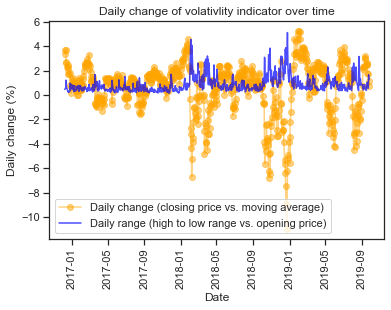

In [8]:
#plot variables    
x = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['Date']
y1 = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['daily_change_close']
y2 = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['daily_change_high']
y3 = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['daily_change_low']
y4 = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['daily_change_low_high']
#y4 = [Y2 if max(abs(Y2), abs(Y3)) == Y2 else Y3 for Y2, Y3 in zip(y2, y3)]
y5 = y2-y3
#plot
plt.ylabel("Daily change (%)")
plt.xlabel("Date")
plt.title('Daily change of volativlity indicator over time')
plt.plot(x, y1, marker='o', label = 'Daily change (closing price vs. moving average)', color='orange', alpha = 0.5)
plt.plot(x, y4, label = 'Daily range (high to low range vs. opening price)', color='blue', alpha = 0.7)
#plt.plot(x, y3, label = 'daily change - low', color='green', alpha = 0.5)
#plt.plot(x, y_train, marker='o', label = 'train set', color='green')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

### Sentiment analysis of the tweets

In [9]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from nltk.tokenize import word_tokenize
#from nltk.corpus import opinion_lexicon

import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Yoyo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yoyo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
#Sentiment analysis of the tweets
sid = SentimentIntensityAnalyzer()
scores = pd.DataFrame()
for text in tweets['text']:
    scores = pd.concat([scores, pd.DataFrame.from_dict(sid.polarity_scores("'''"+text+"'''"), orient='index')], axis=1)

scores = scores.T.reset_index(drop=True)
scores.head()

,neg,neu,pos,compound
0,0.186,0.693,0.121,-0.3612
1,0.000,0.891,0.109,0.6696
2,0.177,0.769,0.054,-0.7514
3,0.200,0.800,0.000,-0.8588
4,0.123,0.877,0.000,-0.7345


### Concatenate sentiment analysis with initial dataframe and convert dates column to regular dates

In [11]:
tweets = pd.concat([tweets, scores[['neg', 'neu', 'pos', 'compound']]], axis=1) #concatenating sentiment analysis to presidents database
#tweets.head()

In [12]:
tweets['length'] = tweets['text'].apply(lambda x: len(x.split())) #add word count feature


### Create a list of financial keywords to determine if the tweets are financial

In [13]:
#importa nltk packages
import nltk.corpus  
from nltk.text import Text 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

### Create a list of financial keywords semantically similar to ['money', 'capital', 'financial_market', 'trade']

In [14]:
#nltk.download()
assert(nltk.download('wordnet'))

def syn(word, lch_threshold=2.5):
    
    '''
    the funciton creates the list of synonyms with financial context from WordNet
    
    The function received the word variable and a threshod to determine word similarity
    and returns the list of synonyms of the word
    ''' 

    lemas = []#np.empty(shape=[0, 2])
    for net1 in wn.synsets(word):
        for net2 in wn.all_synsets():
            try:
                lch = net1.lch_similarity(net2)
            except:
                continue
            if type(lch) == float:
                if lch >= lch_threshold:
                    lemas.append(net2.lemma_names()[0])
    return lemas

#Run function and create the list of financial keywords
financial_list = []
for financial in ['money', 'capital', 'financial_market', 'federal_reserve' 'trade']:
    financial_list.extend(syn(financial))

financial_list

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yoyo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['standard',
 'appropriation',
 'pork_barrel',
 'fund',
 'mutual_fund',
 'revolving_fund',
 'sinking_fund',
 'savings',
 'pension_fund',
 'war_chest',
 'slush_fund',
 'trust_fund',
 'medium_of_exchange',
 'tender',
 'deposit',
 'money',
 'boodle',
 'shinplaster',
 'subsidization',
 'token_money',
 'currency',
 'budget',
 'petty_cash',
 'property',
 'wealth',
 'money',
 'pile',
 'medium_of_exchange',
 'money',
 'sterling',
 'currency',
 'Eurocurrency',
 'cash',
 'hard_currency',
 'paper_money',
 'coinage',
 'possession',
 'share',
 'tax_base',
 'assets',
 'receivables',
 'crown_jewel',
 'deep_pocket',
 'reserve_assets',
 'sum',
 'resource',
 'intangible',
 'liquid_assets',
 'investment',
 'equity',
 'stock',
 'common_stock',
 'no-par-value_stock',
 'preferred_stock',
 'float',
 'common_stock_equivalent',
 'control_stock',
 'growth_stock',
 'hot_stock',
 'authorized_shares',
 'quarter_stock',
 'security',
 'material_resource',
 'capital',
 'venture_capital',
 'capital',
 'operating_capit

### Convert financial list of words to roots of words

In [15]:
# convert financial list of words to word roots


#initiate variables
token_words = financial_list
stem_financial=[]

#initiate stemmer and lamentizer
lemmantizer = WordNetLemmatizer() 
stemmer = SnowballStemmer("english") #SnowballStemmer("english")#PorterStemmer()

#iterate over the list of words
for word in token_words:
    if len(word[0].split())>1:
        stem_financial.append(word)   

    #lamentize the list of financial words
    else:  
        if wn.synsets(word)[0].pos() == 'v':
            stem_financial.append(lemmantizer.lemmatize(word, pos="v")) 
        if wn.synsets(word)[0].pos() == 'a':
            stem_financial.append(lemmantizer.lemmatize(word, pos="a")) 
        if wn.synsets(word)[0].pos() == 'n':
            stem_financial.append(lemmantizer.lemmatize(word, pos="n")) 
        if wn.synsets(word)[0].pos() == 'r':
            stem_financial.append(stemmer.stem(word)) 

stem_financial = [word.replace("_", " ") for word in stem_financial] #replace underscores with spaces
stem_financial = list(set(stem_financial)) #remove duplicates
stem_financial

['Nassau',
 'booklet',
 'Quebec',
 'Kabul',
 'stenograph',
 'Manama',
 'written symbol',
 "Saint John's",
 'Oklahoma City',
 'boodle',
 'Tokyo',
 'treasury stock',
 'Lilongwe',
 'Columbia',
 'Dakar',
 'Regina',
 'preferred stock',
 'no-par-value stock',
 'Castries',
 'Conakry',
 'Dimash',
 'Gran Santiago',
 'wealth',
 'Brazzaville',
 'Abuja',
 'Riyadh',
 'Bridgetown',
 'Amman',
 'character',
 'Lisbon',
 'mathematical symbol',
 'Nashville',
 'pension fund',
 'Canberra',
 'patrimony',
 'Vilnius',
 'asset',
 'Kingstown',
 'asterisk',
 'head',
 'common stock',
 'reference book',
 'Baton Rouge',
 'Tirana',
 'Victoria',
 'tender',
 'Das Kapital',
 'hot stock',
 'Trenton',
 'Harrisburg',
 'Maseru',
 'Sydney',
 'Port of Spain',
 'Bayrut',
 'Sacramento',
 'Indianapolis',
 'Accra',
 'Ljubljana',
 'Astana',
 'Kingston',
 'Charlottetown',
 'deposit',
 'space',
 'Belgrade',
 'Phoenix',
 'Kathmandu',
 'share',
 'sterling',
 'Abu Dhabi',
 'United States government',
 'Djibouti',
 'deep pocket',
 'Ams

### Create additional predictors
- is_financial: indicates whether the tweet is financial
- num_upper: indicatesf on the number of upper case words 

In [16]:
def is_financial_tweet(text, financial_words):
    
    #financial_words = ['finac', 'federal reserve', 'interest', 'negative', 'trade', 'market']
    count_financial = 0
    #count the number of time financial words appear in Trump's tweets
    for word in financial_words:
        count_financial += text.lower().count(word)
    return count_financial
#    return 1 if any(f in text.lower() for f in financial_words) else 0

def num_upper(text):
    return sum(map(str.isupper, text.split()))

tweets['num_upper'] = tweets['text'].apply(num_upper)
tweets['is_financial'] = tweets['text'].apply(lambda x: is_financial_tweet(x, stem_financial))
tweets['country_mentioned'] = tweets['text'].apply(lambda x: is_financial_tweet(x, ['china', 'iran', 'russia', 'israel', 'turkey', 'britain', 'france', 'ukraine', 'japan', 'brasil']))
tweets.head()

,source,text,Date,retweet_count,favorite_count,is_retweet,id_str,hour,neg,neu,pos,compound,length,num_upper,is_financial,country_mentioned
0,Twitter for iPhone,“Serial killers get more Due Process than the ...,2019-10-14,19867.0,74617,false,1.183541e+18,0.0,0.186,0.693,0.121,-0.3612,18,0,0,0
1,Twitter for iPhone,Somebody please explain to Chris Wallace of Fo...,2019-10-14,26122.0,106477,false,1.183535e+18,0.0,0.000,0.891,0.109,0.6696,49,1,0,1
2,Twitter for iPhone,The U.S. has the worst of the ISIS prisoners. ...,2019-10-13,16861.0,67151,false,1.183525e+18,23.0,0.177,0.769,0.054,-0.7514,44,2,0,1
3,Twitter for iPhone,.@marklevinshow on @FoxNews is doing a big sho...,2019-10-13,14569.0,50631,false,1.183520e+18,23.0,0.200,0.800,0.000,-0.8588,42,2,0,0
4,Twitter for iPhone,.....BY THE WAY DON’T CALL ME AGAIN I’LL CALL ...,2019-10-13,18997.0,71535,false,1.183507e+18,22.0,0.123,0.877,0.000,-0.7345,48,19,0,0


### Function that counts nouns, verbs, adverbs and adjectives

In [17]:
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import RegexpTokenizer


def tag_count (tweet, NN, VB, RB, JJ):
    '''
    Returns the number of word types in a tweet
    
    tweet: is a string
    tag_type: is a string of two initial letters of tag type (NN, VB, etc.)
    '''
    
    tokenizer = RegexpTokenizer(r'\w+')
    string = tokenizer.tokenize(tweet) #remove punctuation
    
    string = pd.DataFrame(string)
    string = string[string[0].apply(lambda x: len(x)>3)][0].tolist() #remove words short words

    #count nouns
    tokens = nltk.word_tokenize(' '.join(string))
    #print('\n', list(pd.DataFrame(nltk.pos_tag(tokens))))
    tags = pd.DataFrame(nltk.pos_tag(tokens))
    if list(tags) != []:
        tags = tags.groupby(1).count() #group by word tag
        tags = tags.reset_index()

        tags[1] = tags[1].apply(lambda x: x[0:2]) #select word tag type
        group_count = tags.groupby(1).sum().reset_index() #group by tag type

        #return number of nouns in a string
        #print('\n', group_count[group_count[1] == NN][0].values, group_count[group_count[1] == VB][0].values, group_count[group_count[1] == RB][0].values)
        nouns = [group_count[group_count[1] == NN][0].values 
                 if len(group_count[group_count[1] == NN][0].values)>0 else [0]][0][0]
        verbs = [group_count[group_count[1] == VB][0].values 
                 if len(group_count[group_count[1] == VB][0].values)>0 else [0]][0][0]
        adverbs = [group_count[group_count[1] == RB][0].values 
                 if len(group_count[group_count[1] == RB][0].values)>0 else [0]][0][0]
        adjectives = [group_count[group_count[1] == JJ][0].values 
                 if len(group_count[group_count[1] == JJ][0].values)>0 else [0]][0][0]
        #print('\n', nouns, verbs, adverbs)
        return nouns, verbs, adverbs, adjectives
    else:
        return 0, 0, 0, 0


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yoyo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### Count nouns, verbs, and adverbs

In [18]:
tweets=tweets.join(pd.DataFrame(tweets['text'].apply(lambda x: tag_count(x, 'NN', 'VB', 'RB', 'JJ')).tolist(),
                                                    columns = ['nouns', 'verbs', 'adverbs', 'adjectives']))
#tweets.to_csv('tweets_final.csv')
tweets.head()

,source,text,Date,retweet_count,favorite_count,is_retweet,id_str,hour,neg,neu,pos,compound,length,num_upper,is_financial,country_mentioned,nouns,verbs,adverbs,adjectives
0,Twitter for iPhone,“Serial killers get more Due Process than the ...,2019-10-14,19867.0,74617,false,1.183541e+18,0.0,0.186,0.693,0.121,-0.3612,18,0,0,0,7,1,1,1
1,Twitter for iPhone,Somebody please explain to Chris Wallace of Fo...,2019-10-14,26122.0,106477,false,1.183535e+18,0.0,0.000,0.891,0.109,0.6696,49,1,0,1,15,4,2,0
2,Twitter for iPhone,The U.S. has the worst of the ISIS prisoners. ...,2019-10-13,16861.0,67151,false,1.183525e+18,23.0,0.177,0.769,0.054,-0.7514,44,2,0,1,8,5,2,2
3,Twitter for iPhone,.@marklevinshow on @FoxNews is doing a big sho...,2019-10-13,14569.0,50631,false,1.183520e+18,23.0,0.200,0.800,0.000,-0.8588,42,2,0,0,15,4,1,2
4,Twitter for iPhone,.....BY THE WAY DON’T CALL ME AGAIN I’LL CALL ...,2019-10-13,18997.0,71535,false,1.183507e+18,22.0,0.123,0.877,0.000,-0.7345,48,19,0,0,16,4,2,3


### Sentiment analysis figures

### Distribution of negative and positive scores over time

In [19]:
#Create df with average values

bars_df = tweets[tweets['Date']>datetime.date(2016, 11, 1)].copy()
bars_df['year-month']= bars_df['Date'].map(lambda x: str(x.year) +'-'+ str(x.month))

bars_df = bars_df.loc[:, ['year-month', 'neg', 'pos', 'neu']].groupby(['year-month']).mean().reset_index().T
bars_df.columns = bars_df.iloc[0]
bars_df = bars_df.drop(['year-month'], axis =0)
bars_df

year-month,2016-11,2016-12,2017-1,2017-10,2017-11,2017-12,2017-2,2017-3,2017-4,2017-5,...,2019-1,2019-10,2019-2,2019-3,2019-4,2019-5,2019-6,2019-7,2019-8,2019-9
neg,0.0576,0.0653333,0.0895735,0.0868,0.0857384,0.08016,0.107902,0.0680222,0.0679203,0.0750347,...,0.0961483,0.0914158,0.0815078,0.0942069,0.102625,0.0832611,0.0788425,0.0808675,0.085702,0.074418
pos,0.158194,0.129894,0.10252,0.14631,0.155219,0.168331,0.11819,0.146741,0.148746,0.141736,...,0.126659,0.107663,0.124218,0.121066,0.133489,0.141037,0.136431,0.133271,0.153673,0.126692
neu,0.78423,0.804773,0.807902,0.766882,0.759051,0.751514,0.773922,0.785259,0.783326,0.783229,...,0.777159,0.800941,0.794249,0.784734,0.763873,0.775727,0.784729,0.785859,0.760646,0.798884


In [20]:
#Create df with STDEV values

bars_df_e = tweets[tweets['Date']>datetime.date(2016, 11, 1)].copy()
bars_df_e['year-month']= bars_df_e['Date'].map(lambda x: str(x.year) +'-'+ str(x.month))

bars_df_e = bars_df_e.loc[:, ['year-month', 'neg', 'pos', 'neu']].groupby(['year-month']).std().reset_index().T
bars_df_e.columns = bars_df_e.iloc[0]
bars_df_e = bars_df_e.drop(['year-month'], axis =0)

bars_df_e

year-month,2016-11,2016-12,2017-1,2017-10,2017-11,2017-12,2017-2,2017-3,2017-4,2017-5,...,2019-1,2019-10,2019-2,2019-3,2019-4,2019-5,2019-6,2019-7,2019-8,2019-9
neg,0.0934457,0.0972801,0.109256,0.102587,0.105664,0.0953548,0.124425,0.104762,0.106756,0.100927,...,0.101128,0.117982,0.0985711,0.114591,0.112635,0.0959443,0.0915755,0.0982932,0.10913,0.100972
pos,0.155262,0.123803,0.121608,0.148582,0.145271,0.144363,0.134818,0.142355,0.145522,0.142204,...,0.117432,0.133024,0.114534,0.147444,0.140379,0.132924,0.132081,0.130687,0.14877,0.147041
neu,0.161257,0.142739,0.137292,0.147623,0.152811,0.13962,0.155457,0.155846,0.153736,0.140993,...,0.132314,0.159276,0.128352,0.161963,0.143658,0.136687,0.143894,0.139845,0.153881,0.157464


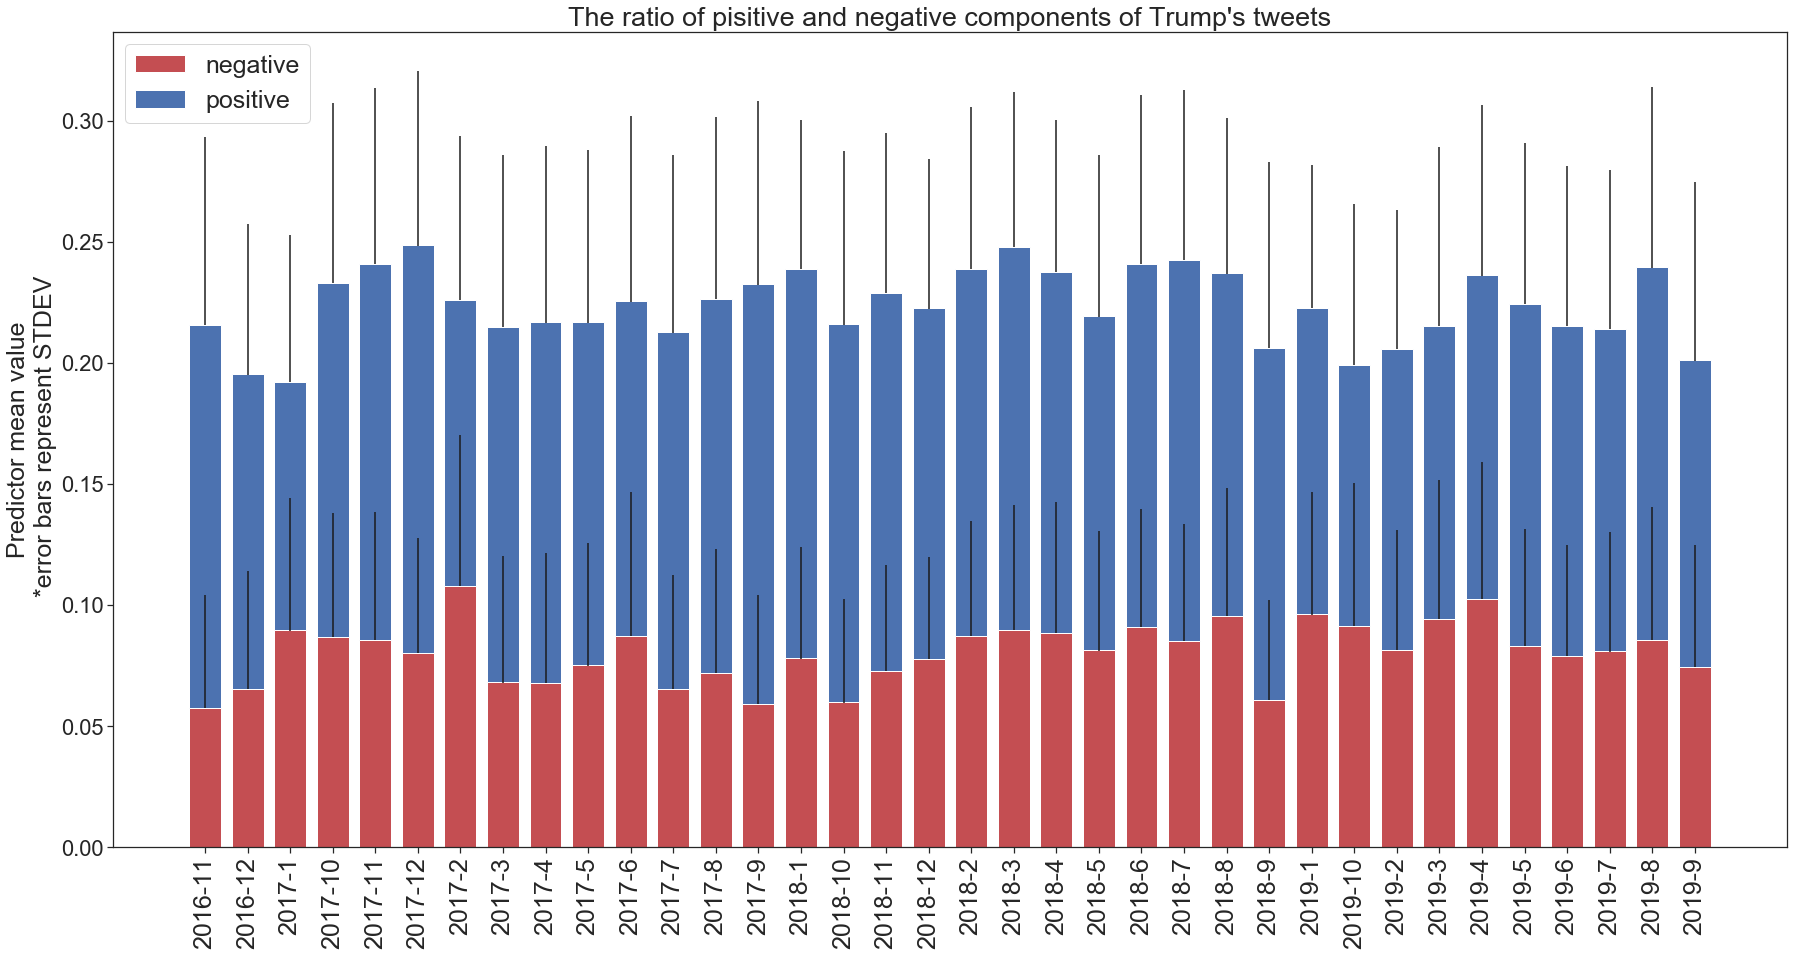

In [21]:
# your code here

plt.figure(figsize=(30, 15)) #figure size
N=len(list(bars_df))

#coefficient variables
neg_bar = bars_df.loc[['neg'], :].values.flatten()
pos_bar = bars_df.loc[['pos'], :].values.flatten()
neg_bar_e = bars_df_e.loc[['neg'], :].values.flatten()
pos_bar_e = bars_df_e.loc[['pos'], :].values.flatten()

#coefficient magnitudes
bars = np.add(neg_bar, pos_bar).tolist()

ind = np.arange(N)    # the x locations for the groups
width = 0.75       # the width of the bars

p1 = plt.bar(ind, neg_bar, width, color='r',edgecolor='white', yerr=[neg_bar_e/1000, neg_bar_e/2])
p2 = plt.bar(ind, pos_bar, width, bottom = neg_bar, color='b', edgecolor='white', yerr=[pos_bar_e/1000, pos_bar_e/2])


plt.ylabel('Predictor mean value\n *error bars represent STDEV', fontsize=25)
plt.title('The ratio of pisitive and negative components of Trump\'s tweets', fontsize=27)
plt.xticks(ind, list(bars_df), rotation='vertical', fontsize=25)
plt.yticks(fontsize=22)
plt.legend((p1[0], p2[0]), ('negative', 'positive'), loc="upper left", fontsize=25)

plt.show()

In [22]:
#Create df with average values
bars_df = tweets[tweets['Date']>datetime.date(2016, 11, 1)].copy()
bars_df['year-month']= bars_df['Date'].map(lambda x: str(x.year) +'-'+ str(x.month))
bars_df['descriptive']=bars_df['adverbs']+bars_df['adjectives']
bars_df = bars_df.loc[:, ['year-month', 'nouns', 'verbs', 'descriptive']].groupby(['year-month']).mean().reset_index().T
bars_df.columns = bars_df.iloc[0]
bars_df = bars_df.drop(['year-month'], axis =0)
bars_df

year-month,2016-11,2016-12,2017-1,2017-10,2017-11,2017-12,2017-2,2017-3,2017-4,2017-5,...,2019-1,2019-10,2019-2,2019-3,2019-4,2019-5,2019-6,2019-7,2019-8,2019-9
nouns,6.82424,6.45455,6.31863,6.93333,8.52743,10.8057,6.62745,6.68889,6.71014,6.61806,...,10.4345,8.66997,9.8342,8.77586,9.21362,9.86946,9.77901,9.23494,8.87585,8.748
verbs,1.93939,2.14394,2.26471,1.93725,2.56962,3.05714,2.06536,1.65926,1.91304,1.86111,...,3.78621,2.74917,3.17098,2.9,3.1517,3.49507,3.52762,3.28313,3.22348,2.964
descriptive,1.98788,2.02273,2.17647,1.95294,2.8692,3.45143,2.0915,1.93333,2.05072,1.91667,...,3.75172,2.81848,3.46632,3.1069,3.30341,3.68966,3.40055,3.50602,3.55305,2.972


In [23]:
#Create df with STDEV values

bars_df_e = tweets[tweets['Date']>datetime.date(2016, 11, 1)].copy()
bars_df_e['year-month']= bars_df_e['Date'].map(lambda x: str(x.year) +'-'+ str(x.month))
bars_df_e['descriptive']=bars_df_e['adverbs']+bars_df_e['adjectives']
bars_df_e = bars_df_e.loc[:, ['year-month', 'nouns', 'verbs', 'descriptive']].groupby(['year-month']).std().reset_index().T
bars_df_e.columns = bars_df_e.iloc[0]
bars_df_e = bars_df_e.drop(['year-month'], axis =0)

bars_df_e


year-month,2016-11,2016-12,2017-1,2017-10,2017-11,2017-12,2017-2,2017-3,2017-4,2017-5,...,2019-1,2019-10,2019-2,2019-3,2019-4,2019-5,2019-6,2019-7,2019-8,2019-9
nouns,2.73628,2.45684,2.16589,2.59305,3.71841,4.58596,2.414,2.54941,2.51478,2.47221,...,4.67758,5.05303,4.95537,4.65354,4.33757,4.3188,4.66386,4.71427,4.62292,4.82774
verbs,1.39554,1.38769,1.48839,1.28436,1.87094,1.95558,1.34102,1.29386,1.35882,1.38226,...,2.5388,2.47567,2.38851,2.51232,2.33364,2.33571,2.6095,2.61365,2.49655,2.57293
descriptive,1.78403,1.61796,1.5499,1.49202,2.30598,2.51357,1.65974,1.61245,1.69293,1.60201,...,2.74406,2.50629,2.78765,2.73241,2.82088,2.62321,2.46803,2.97491,2.86084,2.71919


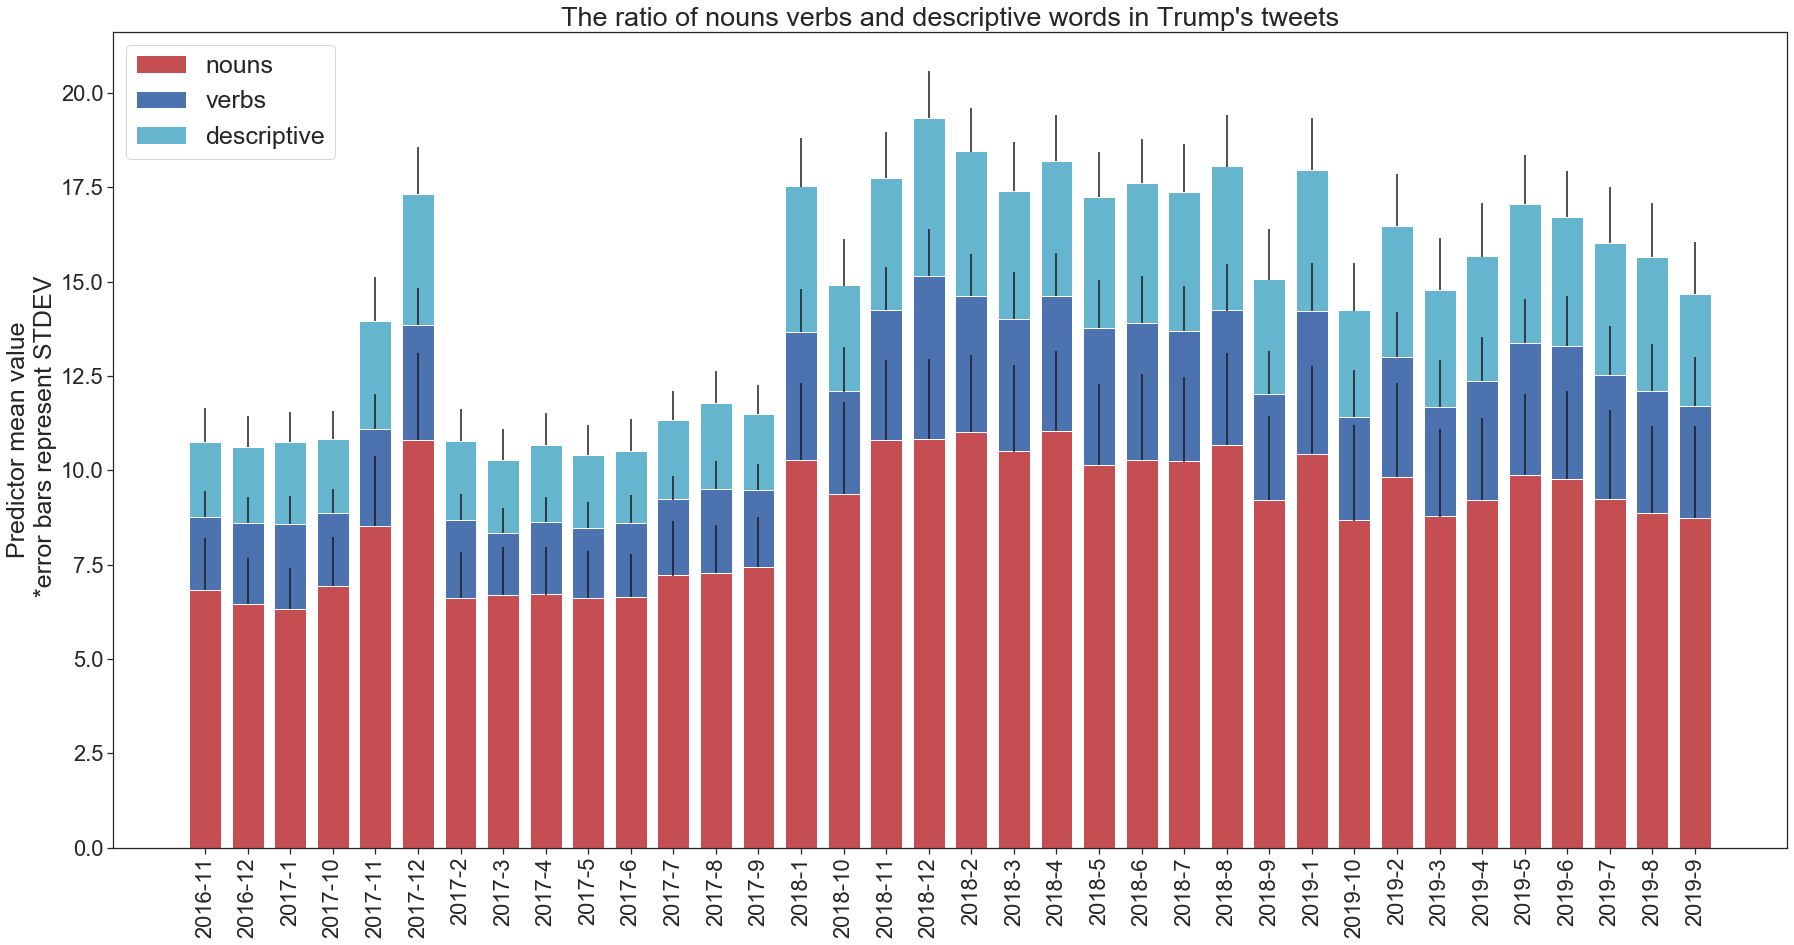

In [24]:
# your code here

plt.figure(figsize=(30, 15)) #figure size
N=len(list(bars_df))

#coefficient variables
nouns_bar = bars_df.loc[['nouns'], :].values.flatten()
verbs_bar = bars_df.loc[['verbs'], :].values.flatten()
adverbs_bar = bars_df.loc[['descriptive'], :].values.flatten()

nouns_bar_e = bars_df_e.loc[['nouns'], :].values.flatten()
verbs_bar_e = bars_df_e.loc[['verbs'], :].values.flatten()
adverbs_bar_e = bars_df_e.loc[['descriptive'], :].values.flatten()


#coefficient magnitudes
bars = np.add(nouns_bar, verbs_bar).tolist()

ind = np.arange(N)    # the x locations for the groups
width = 0.75       # the width of the bars

p1 = plt.bar(ind, nouns_bar, width, color='r',edgecolor='white', yerr=[nouns_bar_e/1000, nouns_bar_e/2])
p2 = plt.bar(ind, verbs_bar, width, bottom = nouns_bar, color='b', edgecolor='white', yerr=[verbs_bar_e/1000, verbs_bar_e/2])
p3 = plt.bar(ind, adverbs_bar, width, bottom = bars, color='c', edgecolor='white', yerr=[adverbs_bar_e/1000, adverbs_bar_e/2])

plt.ylabel('Predictor mean value\n *error bars represent STDEV', fontsize=25)
plt.title('The ratio of nouns verbs and descriptive words in Trump\'s tweets', fontsize=27)
plt.xticks(ind, list(bars_df), rotation='vertical', fontsize=22)
plt.yticks(fontsize=22)
plt.legend((p1[0], p2[0], p3[0]), ('nouns', 'verbs', 'descriptive'), loc="upper left", fontsize=25)

plt.show()

### Drop unnecessary tweets columns

In [25]:
tweets['favorite_count'] = pd.to_numeric(tweets['favorite_count'])
tweets['retweet_count'] = pd.to_numeric(tweets['retweet_count'])

In [26]:
tweets_count = pd.DataFrame({'tweet_count':tweets['Date'].value_counts(dropna=False)}).rename_axis('Date').reset_index()
tweets_count.head()

,Date,tweet_count
0,2015-01-05,141
1,2015-01-06,107
2,2013-07-24,88
3,2016-10-20,87
4,2013-02-27,86


In [27]:
tweets_by_date = tweets.drop(['source','text','is_retweet', 'id_str'], axis = 1).groupby(['Date']).mean().reset_index()
tweets_by_date = tweets_by_date.merge(tweets_count, on='Date', how='left')
tweets_by_date.tail(20)

,Date,retweet_count,favorite_count,hour,neg,neu,pos,compound,length,num_upper,is_financial,country_mentioned,nouns,verbs,adverbs,adjectives,tweet_count
2989,2019-09-25,17074.304348,65088.260870,10.956522,0.045174,0.883957,0.070783,0.031443,19.217391,1.086957,0.260870,0.304348,6.695652,2.521739,0.652174,0.826087,23
2990,2019-09-26,16470.052632,69631.631579,13.578947,0.131947,0.698632,0.169474,0.137826,21.578947,2.684211,0.421053,0.105263,7.684211,1.578947,0.684211,1.473684,19
2991,2019-09-27,21337.136364,79088.409091,9.045455,0.072455,0.887682,0.039909,-0.161205,23.045455,1.954545,0.045455,0.318182,6.590909,2.954545,1.227273,1.590909,22
2992,2019-09-28,26257.923077,111616.076923,14.461538,0.101231,0.777615,0.121154,0.056792,22.153846,2.307692,0.076923,0.153846,6.769231,1.769231,1.384615,1.615385,13
2993,2019-09-29,19495.125000,72159.000000,14.250000,0.064313,0.829875,0.105812,0.015494,21.250000,0.812500,0.250000,0.062500,6.562500,2.375000,1.375000,1.437500,16
2994,2019-09-30,19440.121212,75423.666667,10.909091,0.062455,0.855030,0.082545,0.087415,29.727273,2.060606,0.151515,0.363636,9.696970,2.909091,1.303030,1.272727,33
2995,2019-10-01,26376.400000,104304.066667,13.866667,0.053867,0.851667,0.094467,0.137720,31.133333,1.066667,0.133333,0.066667,9.533333,2.933333,1.466667,1.466667,15
2996,2019-10-02,29192.150000,104145.350000,15.300000,0.103850,0.791000,0.105150,0.026060,33.050000,1.750000,0.450000,0.050000,10.100000,3.600000,1.100000,2.000000,20
2997,2019-10-03,16996.080000,65096.440000,15.880000,0.087000,0.779840,0.133120,0.101512,17.000000,0.520000,0.240000,0.040000,6.800000,1.680000,0.800000,1.320000,25
2998,2019-10-04,20565.172414,78005.172414,12.103448,0.071379,0.873759,0.054862,-0.004862,24.482759,0.862069,0.206897,0.034483,7.931034,2.137931,0.862069,1.655172,29


In [28]:
tweets_by_date = tweets_by_date[tweets_by_date['Date']>datetime.date(2016, 11, 1)]
tweets_by_date = tweets_by_date[tweets_by_date['Date']<datetime.date(2019, 9, 26)]
CBOE = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]
CBOE = CBOE[CBOE['Date']<datetime.date(2019, 9, 26)]

### Merge response variable and tweet related features

### Perform outer mege of tweet features with financial indicator
- Add zeroes for days with not tweets.
- Add Monday's financial indicator value as response to Saturday and Sunday tweets

In [29]:
datamerge = tweets_by_date.merge(CBOE, on='Date', how='outer')

datamerge = datamerge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
datamerge = datamerge[datamerge['Date']<datetime.date(2019, 9, 26)]

#Impute Staurday and Sunday values
datamerge['daily_change_low'] = datamerge['daily_change_low'].fillna(datamerge['daily_change_low'].rolling(2, min_periods=1).mean().shift(-2))
datamerge['daily_change_high'] = datamerge['daily_change_high'].fillna(datamerge['daily_change_high'].rolling(2, min_periods=1).mean().shift(-2))
datamerge['daily_change_close'] = datamerge['daily_change_close'].fillna(datamerge['daily_change_close'].rolling(2, min_periods=1).mean().shift(-2))
datamerge['daily_change_low_high'] = datamerge['daily_change_low_high'].fillna(datamerge['daily_change_low_high'].rolling(2, min_periods=1).mean().shift(-2))
datamerge['Adj Close'] = datamerge['Adj Close'].fillna(datamerge['Adj Close'].rolling(2, min_periods=1).mean().shift(-2))
datamerge['moving_avg'] = datamerge['moving_avg'].fillna(datamerge['moving_avg'].rolling(2, min_periods=1).mean().shift(-2))

#Define days with missing tweets as 1
datamerge['no_tweet'] = datamerge['length'].map(lambda x: 1 if np.isnan(x) else 0)

#Impute of missing feature values as 0
#datamerge[datamerge['length'].isna().any(axis=1)] = datamerge[datamerge['length'].isnull()].fillna(0)
datamerge[datamerge['length'].isna()] = datamerge[datamerge['length'].isna()].fillna(0)

datamerge[datamerge['retweet_count'].isna()] = datamerge[datamerge['retweet_count'].isna()].fillna(0)
#print('Numpber of NaN tweet rows after imputation:', len(datamerge[datamerge['daily_change_low'].isna()]))
#print('Numpber of NaN tweet rows after imputation:', len(datamerge[datamerge.isna().any(axis=1)]))

datamerge = datamerge.sort_values(by='Date')

#drop NaN values that are not related to imputed values
datamerge = datamerge.dropna(axis=0, subset=['daily_change_close'])
datamerge = datamerge.dropna(axis=0, subset=['daily_change_low'])
datamerge = datamerge.dropna(axis=0, subset=['daily_change_high'])

datamerge.tail()

,Date,retweet_count,favorite_count,hour,neg,neu,pos,compound,length,num_upper,...,adverbs,adjectives,tweet_count,Adj Close,moving_avg,daily_change_close,daily_change_high,daily_change_low,daily_change_low_high,no_tweet
1026,2019-09-21,15857.117647,57961.176471,17.352941,0.099118,0.825824,0.075059,-0.138959,24.705882,0.470588,...,1.000000,1.705882,17.0,2979.190063,2966.250000,1.209759,2.037384,0.896864,1.120380,0
1027,2019-09-22,19649.125000,80410.687500,12.000000,0.077188,0.800250,0.122500,0.031713,22.187500,0.375000,...,1.437500,1.625000,16.0,2991.780029,2965.107143,1.714829,1.965391,1.390146,0.567117,0
1028,2019-09-23,19151.636364,80758.727273,12.727273,0.082727,0.814091,0.103091,0.025309,23.545455,0.454545,...,0.909091,1.363636,11.0,2966.600098,2967.392857,0.704690,2.109378,0.403583,1.673644,0
1029,2019-09-24,25912.066667,107750.800000,15.533333,0.069933,0.820933,0.109133,-0.066920,17.400000,0.666667,...,1.000000,1.333333,15.0,2984.870117,2968.406067,1.156541,1.324294,0.071729,1.245135,0
1030,2019-09-25,17074.304348,65088.260870,10.956522,0.045174,0.883957,0.070783,0.031443,19.217391,1.086957,...,0.652174,0.826087,23.0,2402.619995,2396.529641,1.171761,1.492007,0.732113,0.750315,0


### Parth and Katrine to provide code for imputation of missting days stock market days
- As we impute we put Monday's value for saturday and Sunday.

### Create threshold variable for binary classification (Median)

In [30]:
datamerge['daily_change_low_high'].median()

0.6387194469741241

In [31]:
type(datamerge['daily_change_low_high'])

pandas.core.series.Series

In [32]:
from sklearn.preprocessing import power_transform

In [33]:
#Set threshold for daily change variable

#datamerge['change'] = (datamerge['daily_change_low_high'].map(lambda x: 1 if (abs(x) > datamerge['daily_change_low_high'].abs().median()) else 0))
datamerge['change'] = (datamerge['daily_change_low_high'].map(lambda x: 1 if (x > datamerge['daily_change_low_high'].median()) else 0))
#temp_tr = pd.Series(power_transform(datamerge['daily_change_low_high'].values.reshape(-1,1), method='yeo-johnson', standardize=False).reshape(1,-1)[0])
#datamerge['change'] = temp_tr.map(lambda x: 1 if (abs(x) > temp_tr.abs().mean()) else 0)
#datamerge['change'] = datamerge['daily_change'].map(lambda x: 1 if x > 1.7 else 0)

datamerge.head()

,Date,retweet_count,favorite_count,hour,neg,neu,pos,compound,length,num_upper,...,adjectives,tweet_count,Adj Close,moving_avg,daily_change_close,daily_change_high,daily_change_low,daily_change_low_high,no_tweet,change
32,2016-12-06,21109.600000,75222.600000,17.600000,0.094400,0.884800,0.020800,-0.239360,18.000000,0.200000,...,0.400000,5.0,2259.530029,2233.809274,3.696176,3.708568,3.223478,0.469837,0,0
33,2016-12-07,9467.500000,43229.750000,13.000000,0.000000,0.871750,0.128250,0.323650,15.000000,1.000000,...,0.250000,4.0,2259.530029,2233.809274,3.696176,3.708568,3.223478,0.469837,0,0
34,2016-12-08,11400.000000,48998.800000,13.400000,0.057400,0.748200,0.194400,0.400440,20.600000,0.400000,...,1.400000,5.0,2259.530029,2233.809274,3.696176,3.708568,3.223478,0.469837,0,0
35,2016-12-09,7933.000000,33396.666667,14.666667,0.000000,0.956667,0.043333,0.152467,16.000000,1.000000,...,0.666667,3.0,2256.959961,2235.842494,3.332243,3.655938,3.122103,0.516193,0,0
36,2016-12-10,12998.571429,51251.285714,12.000000,0.065571,0.761857,0.172429,0.300100,19.714286,2.571429,...,1.000000,7.0,2264.339966,2236.907676,3.522775,3.817249,3.225960,0.572015,0,0


datamerge = datamerge.drop(['hour'], axis=1)

In [34]:
### Figures of Trump's tweets over time

In [308]:
# Standardize the data attributes for the Iris dataset.
from sklearn.datasets import load_iris
from sklearn import preprocessing

# standardize the data attributes
preprocessing.scale(y2)


array([-1.91014032, -1.92246276, -1.85169447, -1.94010655, -1.89815383,
       -1.91714024, -1.89575653, -1.85629709, -1.88305131, -1.90328437,
       -1.88971529, -1.86531154, -1.95621691, -1.95938092, -2.00938824,
       -1.9182909 , -1.85634508, -1.86473563, -1.82647484, -1.86521556,
       -1.86521556, -1.83443345, -1.85783169, -1.83769462, -1.87005814,
       -1.85087976, -1.89019522, -1.85365983, -1.88295533, -1.81165912,
       -1.72391776, -1.73202152, -1.74156272, -1.8076804 , -1.8174124 ,
       -1.8141524 , -1.80791919, -1.72847357, -1.75177465, -1.74928137,
       -1.74165871, -1.6783691 , -1.63890966, -1.58065578, -1.53592182,
       -1.47996925, -1.48970242, -1.47081199, -1.40263297, -1.41490625,
       -1.41015964, -1.39323457, -1.38168002, -1.41097552, -1.25601383,
       -1.32333015, -1.3175757 , -1.35502178, -1.38820118, -1.41413953,
       -1.40507709, -1.36801495, -1.36384426, -1.40229702, -1.30731578,
       -1.32591942, -1.34092595, -1.36384426, -1.50504489, -1.48

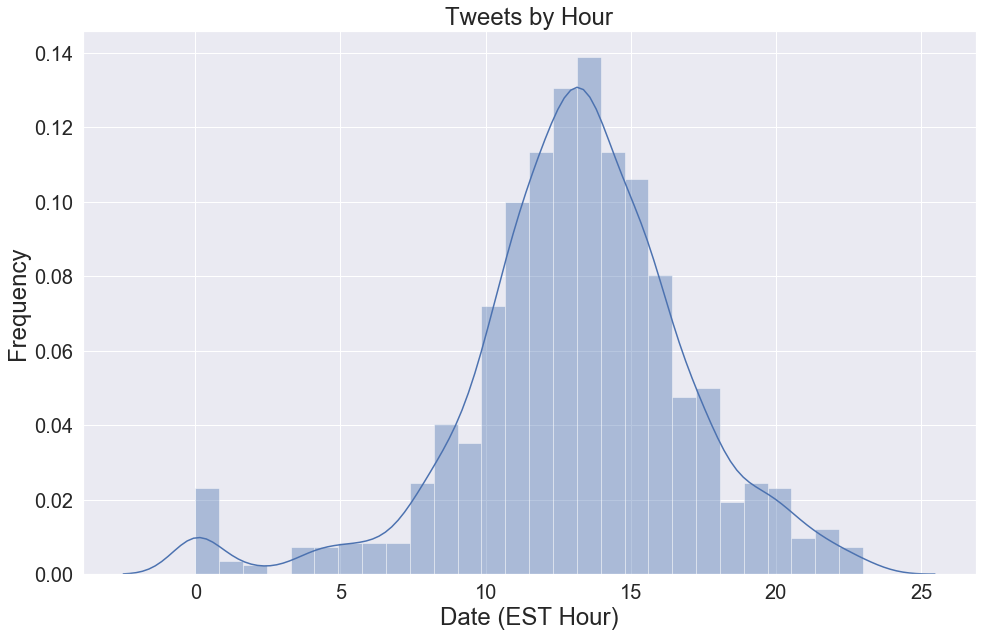

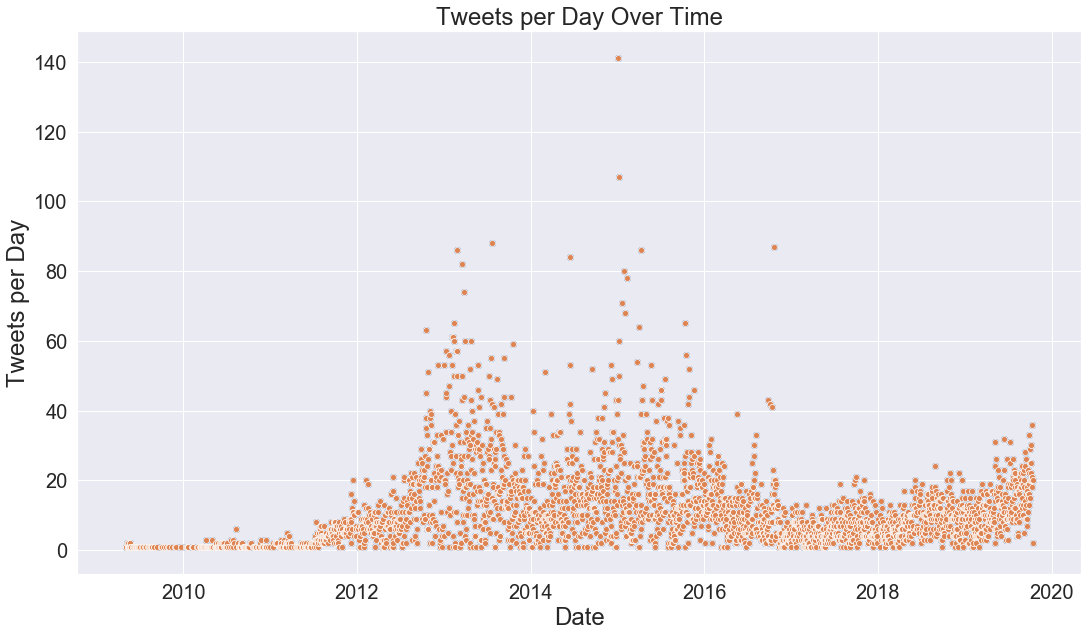

In [553]:
#Generate the plots of Trump's tweet frequency over time

datamerge['DateEST'] = datamerge.Date
plt.figure(figsize=(16,10))
sns.distplot(datamerge['hour'])
plt.ylabel("Frequency", fontsize=24)
plt.xlabel("Date (EST Hour)", fontsize=24)
plt.title("Tweets by Hour", fontsize=24);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


f = tweets.groupby(['Date']).count().reset_index()
d = (f.Date >= datetime.date(year=2007,month=1,day=1))
#display(f)
plt.figure(figsize=(18,10))
plt.scatter(f['Date'], f['is_retweet'])
sns.scatterplot(x='Date', y='is_retweet', data=f[d])
plt.ylabel("Tweets per Day", fontsize=24)
plt.xlabel("Date", fontsize=24)
plt.title("Tweets per Day Over Time", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

datamerge = datamerge.drop(['DateEST'], axis=1)

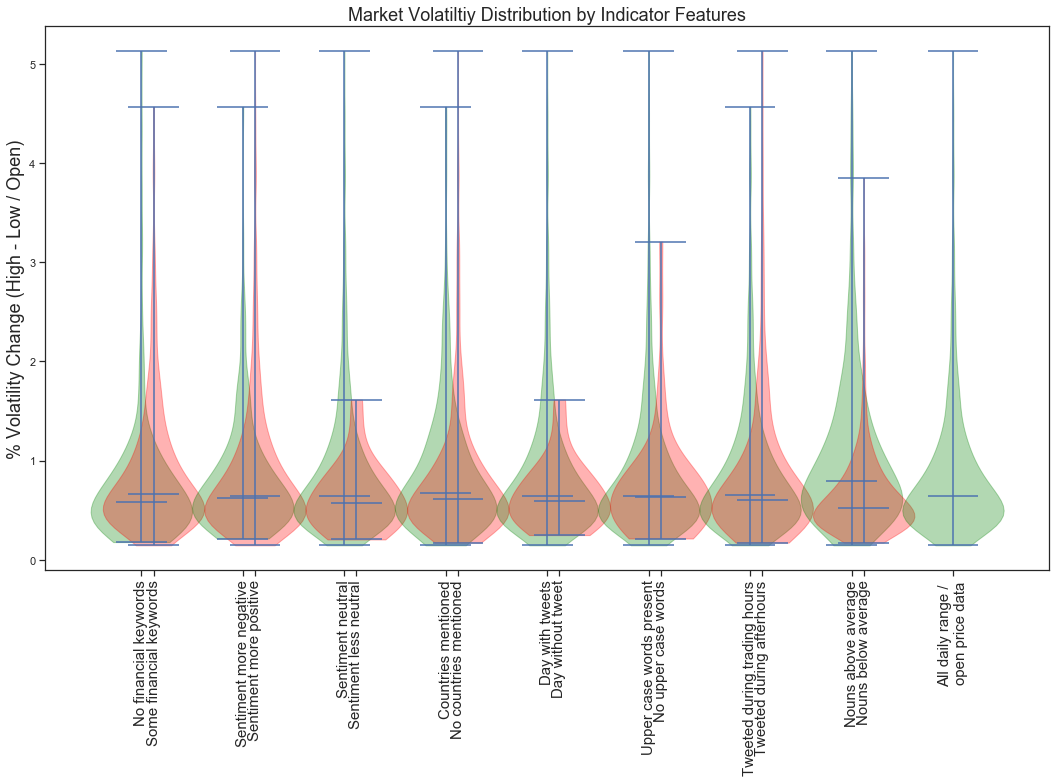

In [36]:
def violin_plot(df, dist_column, masks):
    '''
    
    Plots the effect of indicator features on stock market volatiltiy indicator
    
    Receives fianl dataset containing the predictors, response variable column, and filters by indicator variables
    
    '''
    to_plot_violins = [df[m][dist_column].values.reshape(-1,1) for (m,_,_,_) in masks]
    to_plot_violins_labels = [l for (_,l,_, _) in masks]
    positions = [p for (_,_,p,_) in masks]
    plt.figure(figsize=(18,10))
    plt.title("Market Volatiltiy Distribution by Indicator Features", fontsize=18)
    plt.ylabel("% Volatility Change (High - Low / Open)", fontsize=18)
    plt.xticks(list(positions), list(to_plot_violins_labels))

    violin_parts = plt.violinplot(dataset=to_plot_violins, positions=positions, showmedians=True, showextrema=True)

    for i, p in enumerate(violin_parts['bodies']):
        (_, _, _, c) = masks[i]
        p.set_facecolor(c)
        p.set_edgecolor(c)


    plt.xticks(fontsize=15, rotation=90)
    plt.show()

violin_plot(
    datamerge,
    'daily_change_low_high',
    masks=[
        ((datamerge.is_financial == 0), "No financial keywords", 0.0, "green"),
        ((datamerge.is_financial != 0), "Some financial keywords", 0.06, "red"),
        ((datamerge.neg > datamerge.pos), "Sentiment more negative", 0.5, "green"),
        ((datamerge.neg <= datamerge.pos), "Sentiment more positive", 0.56, "red"),
        ((datamerge.neu > datamerge.pos+datamerge.neg), "Sentiment neutral", 1.0, "green"),
        ((datamerge.neu <= datamerge.pos+datamerge.neg), "Sentiment less neutral", 1.06, "red"),
        ((datamerge.country_mentioned > 0), "Countries mentioned", 1.5, "green"),
        ((datamerge.country_mentioned == 0), "No countries mentioned", 1.56, "red"),
        ((datamerge.no_tweet == 0), "Day with tweets", 2.0, "green"),
        ((datamerge.no_tweet == 1), "Day without tweet", 2.06, "red"),
        ((datamerge.num_upper > 0), "Upper case words present", 2.5, "green"),
        ((datamerge.num_upper == 0), "No upper case words", 2.56, "red"),
        (((datamerge.hour >= 9.5) & (datamerge.hour <= 16.5)), "Tweeted during trading hours", 3.0, "green"),
        (((datamerge.hour < 9.5) | (datamerge.hour > 16.5)), "Tweeted during afterhours", 3.06, "red"),
        ((datamerge.nouns > datamerge.nouns.mean()), "Nouns above average", 3.50, "green"),
        ((datamerge.nouns < datamerge.nouns.mean()), "Nouns below average", 3.56, "red"),
        ((datamerge.no_tweet != -1), "All daily range / \nopen price data", 4.0, "Green"),
    ]
)

### Plot interactions among features and the response variable

#### Frequency of word catergorises were substracted from the length variable to reduce collinearity among variables. As the compound variable was collinear with neg and pos sentiments, this variable was not incorporated in to the model.

In [37]:
datamerge['res_length'] = datamerge['length']-(datamerge['nouns']+datamerge['verbs']+datamerge['adverbs']+datamerge['adjectives'])
datamerge = datamerge.drop(['length'], axis=1) #variable removed as it is collinear with nouns, verbs, adverbes and adjectives.

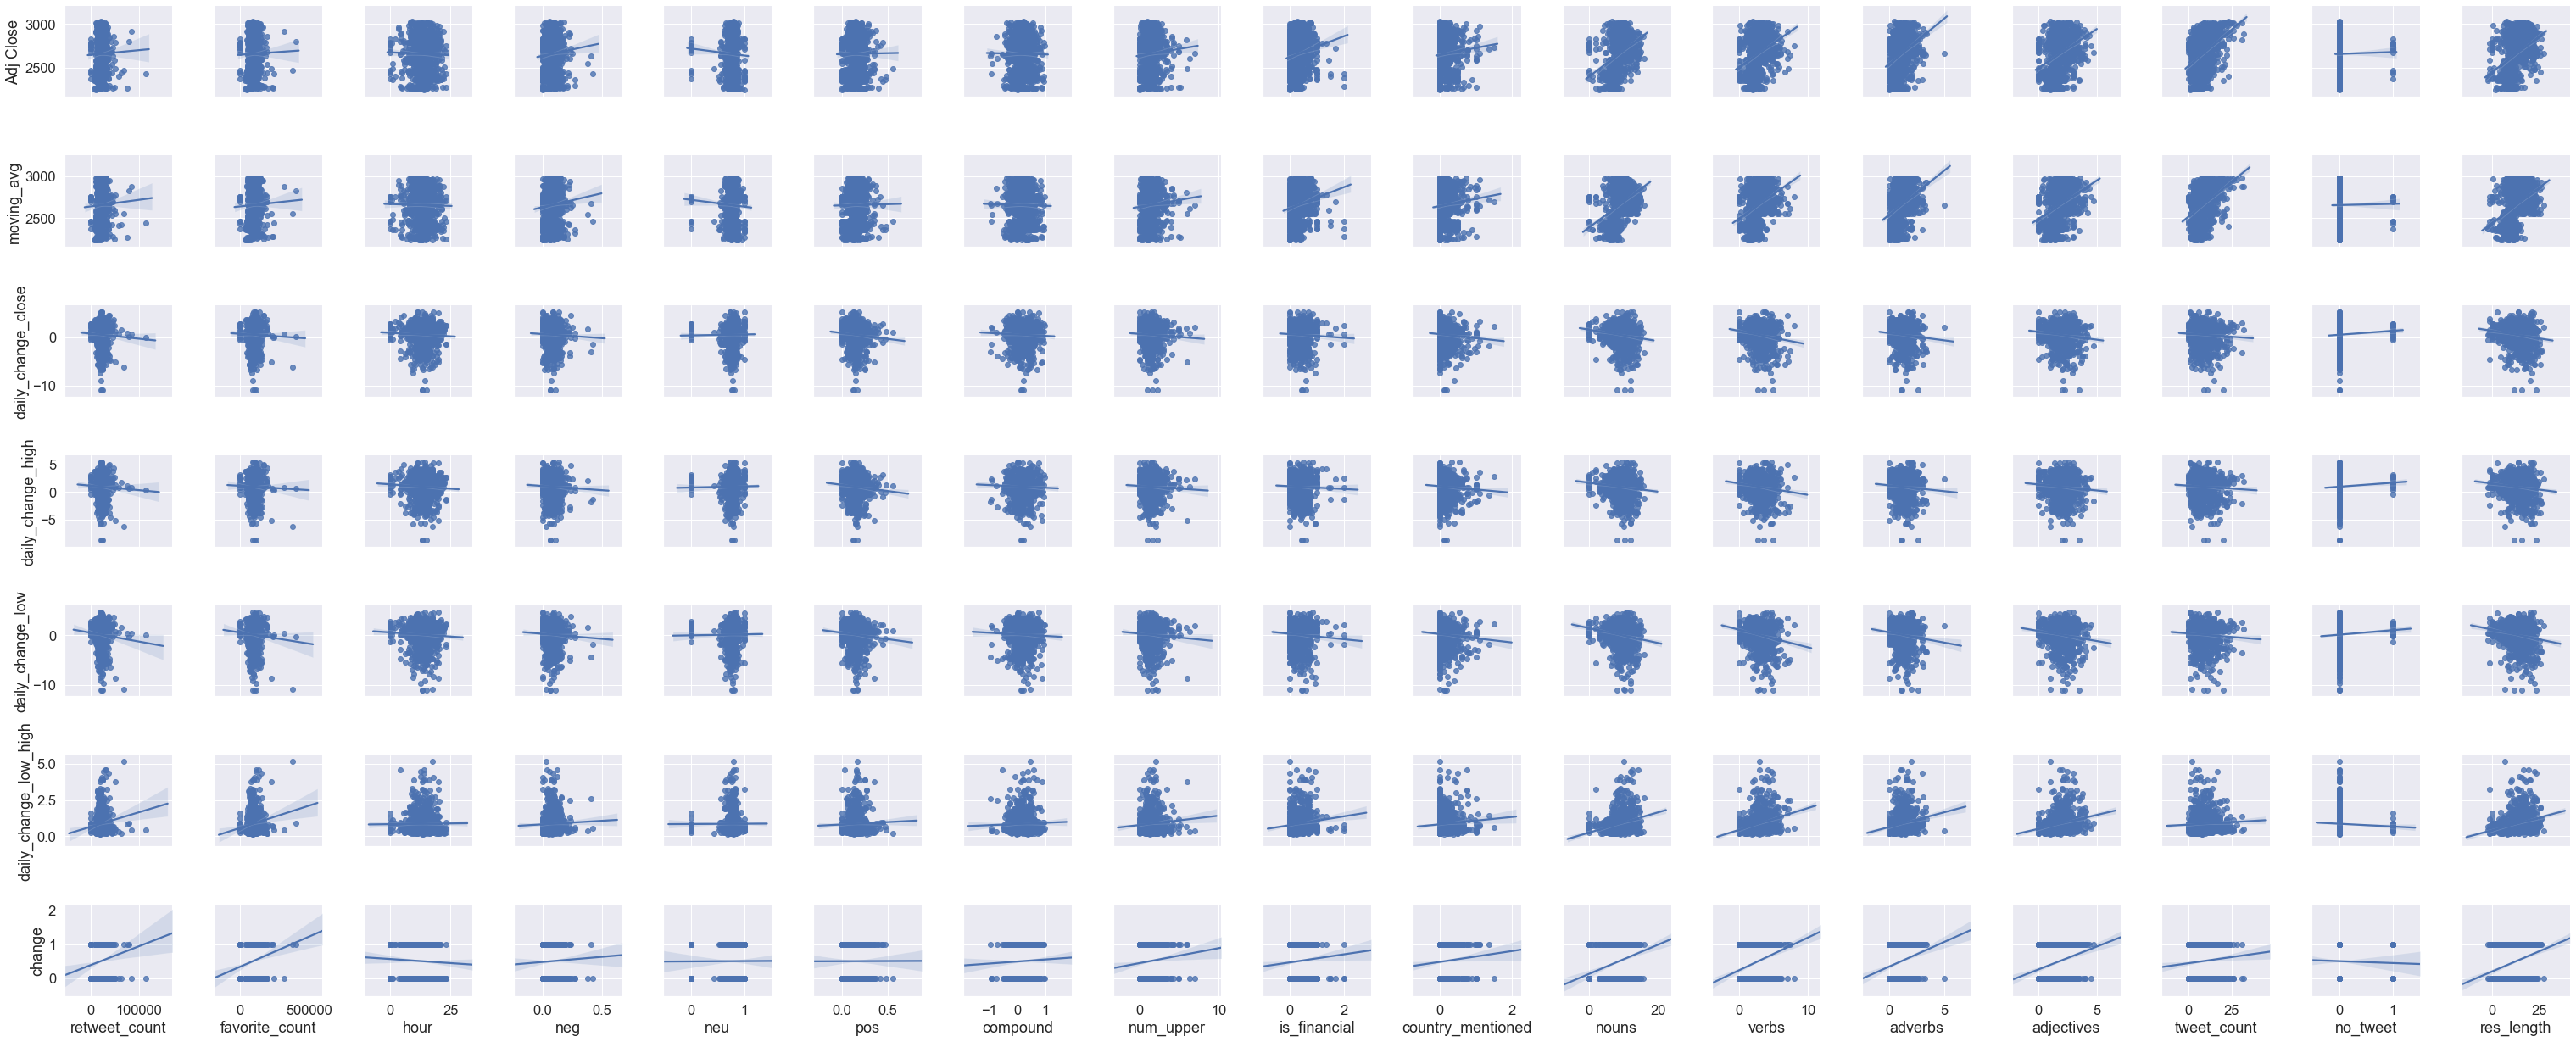

In [38]:
sns.set(font_scale=1.5)
df = datamerge[datamerge['Date']>datetime.date(2016, 11, 1)].drop(['Date'], axis=1)
sns.pairplot(data = df,
                  y_vars=['Adj Close', 'moving_avg', 'daily_change_close','daily_change_high', 'daily_change_low', 'daily_change_low_high', 'change'],
                  x_vars=list(df.drop(['Adj Close', 'moving_avg', 'daily_change_close','daily_change_high', 'daily_change_low', 'daily_change_low_high', 'change'], axis =1)), kind="reg")

### Plot interations among predictors

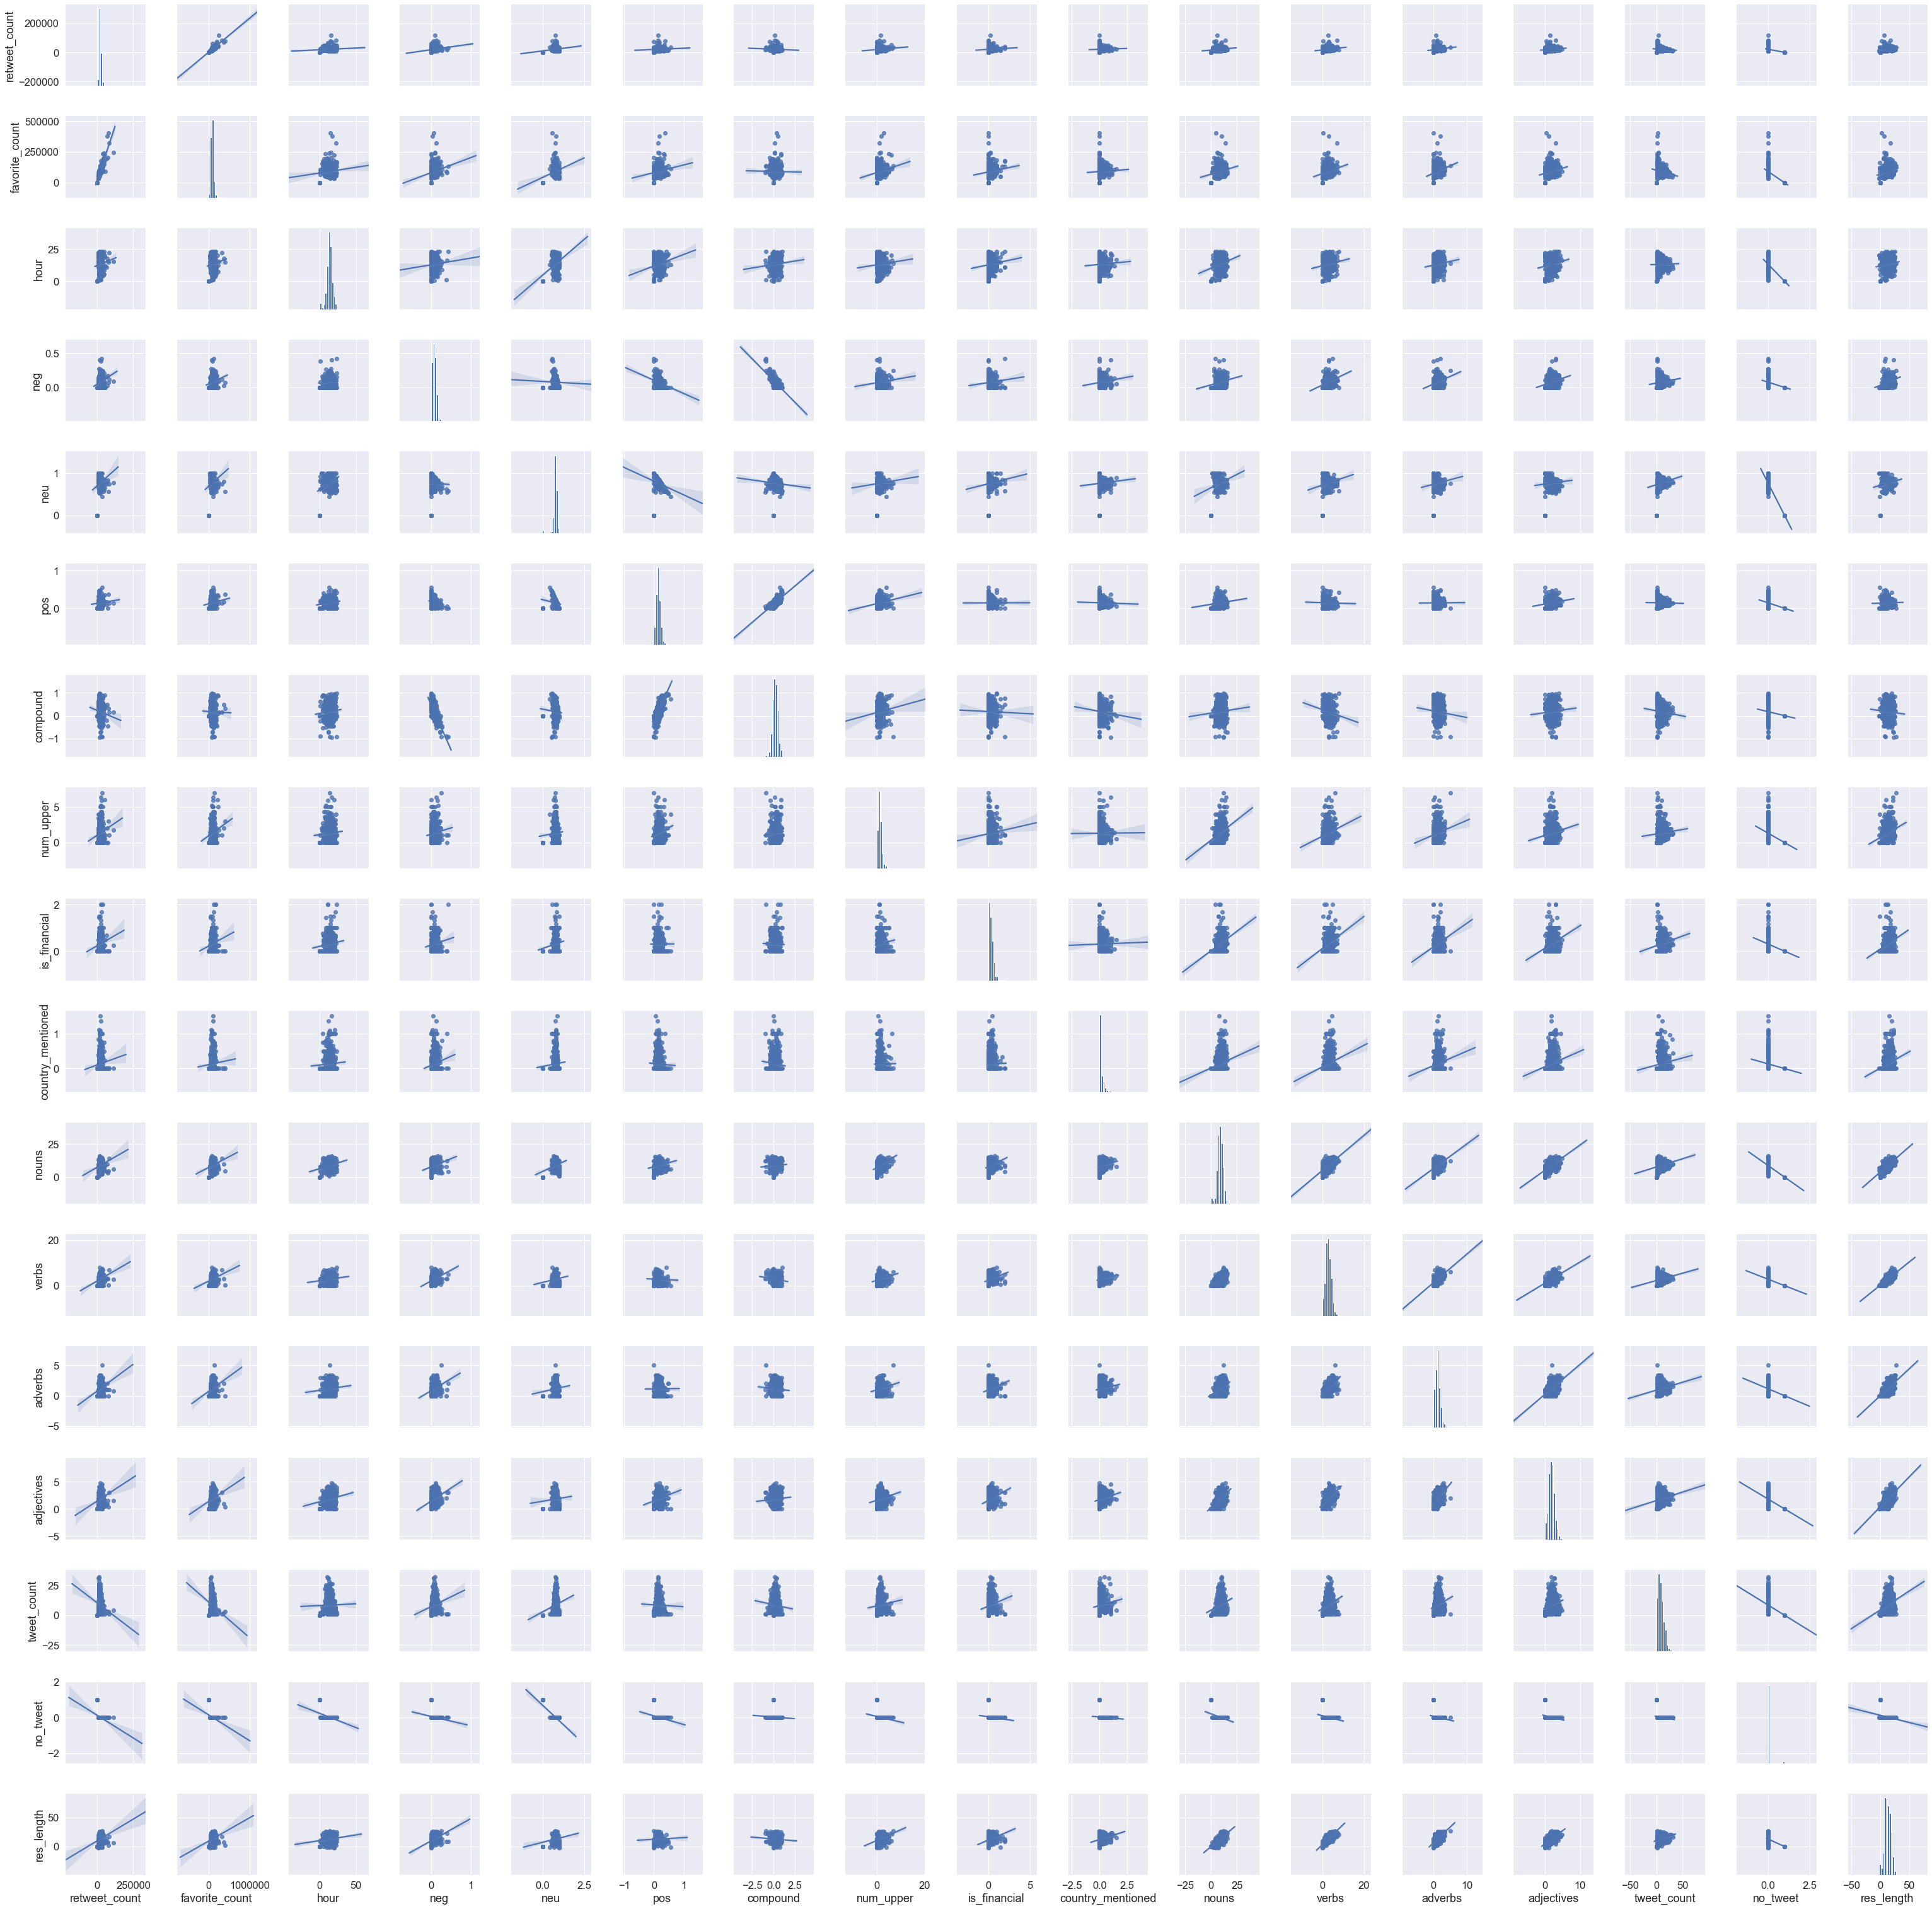

In [39]:
sns.set(font_scale=1.5)
df = datamerge[datamerge['Date']>datetime.date(2016, 11, 1)].drop(['Date'], axis=1)
sns.pairplot(data = df,
                  y_vars=list(df.drop(['Adj Close', 'moving_avg', 'daily_change_close','daily_change_high', 'daily_change_low', 'daily_change_low_high', 'change'], axis =1)),
                  x_vars=list(df.drop(['Adj Close', 'moving_avg', 'daily_change_close','daily_change_high', 'daily_change_low', 'daily_change_low_high', 'change'], axis =1)), kind="reg")

### Split data and determine to train and test datasets and drop unnecessary columns for model generation

In [40]:
list(datamerge)

['Date',
 'retweet_count',
 'favorite_count',
 'hour',
 'neg',
 'neu',
 'pos',
 'compound',
 'num_upper',
 'is_financial',
 'country_mentioned',
 'nouns',
 'verbs',
 'adverbs',
 'adjectives',
 'tweet_count',
 'Adj Close',
 'moving_avg',
 'daily_change_close',
 'daily_change_high',
 'daily_change_low',
 'daily_change_low_high',
 'no_tweet',
 'change',
 'res_length']

In [41]:
sns.set(font_scale=1)
#Split to train and test sets
X_train, X_test, y_train, y_test =train_test_split(datamerge.loc[:, list(datamerge.drop(['compound', 'Adj Close', 'moving_avg', 'daily_change_low', 'daily_change_high', 'daily_change_low_high','daily_change_close', 'Date', 'moving_avg', 'change'], axis=1))], 
                                                         datamerge.change, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = datamerge.change)



In [42]:
X_train.shape

(799, 16)

## Calcualte t-statistic of each feature with regards to stock market volatility indicator

In [407]:
from math import sqrt

t_data = datamerge.drop(['Adj Close', 'moving_avg', 'daily_change_low', 'daily_change_high', 'daily_change_low_high','daily_change_close', 'Date', 'moving_avg'], axis=1)

t_stat = pd.DataFrame()
for x in t_data.drop(['change'], axis=1).columns:
    df1 = df[df['change']==0]
    df2 = df[df['change']==1]
    mean1=df1.loc[:, x].mean()
    std1=df1.loc[:, x].std()
    n1 = df1.loc[:, x].count()
    mean2=df2.loc[:, x].mean()
    std2 = df2.loc[:, x].std()
    n2 = df2.loc[:, x].count()
    t_stat.loc[0, x] = abs(mean1-mean2)/sqrt(std1**2/n1+std2**2/n2)
    
#t_stat.T.rename(columns={0: "t-statistic"}) #calculated t-statistic for each feature:
sig_variables = t_stat.T.sort_values(0).reset_index()
sig_variables = sig_variables.rename(columns={'index':'Predictors', 0:'t-Statistic'})
sig_variables = sig_variables.sort_values(by=['t-Statistic'], ascending=False)
t_stat = t_stat.sort_values(by=0, axis=1, ascending=False)
sig_variables

,Predictors,t-Statistic
16,res_length,8.491517
15,verbs,8.232335
14,nouns,7.579926
13,adjectives,7.252414
12,adverbs,6.410645
11,favorite_count,3.793288
10,retweet_count,3.061613
9,tweet_count,2.476251
8,num_upper,2.417248
7,is_financial,2.122675


<Figure size 2160x1080 with 0 Axes>

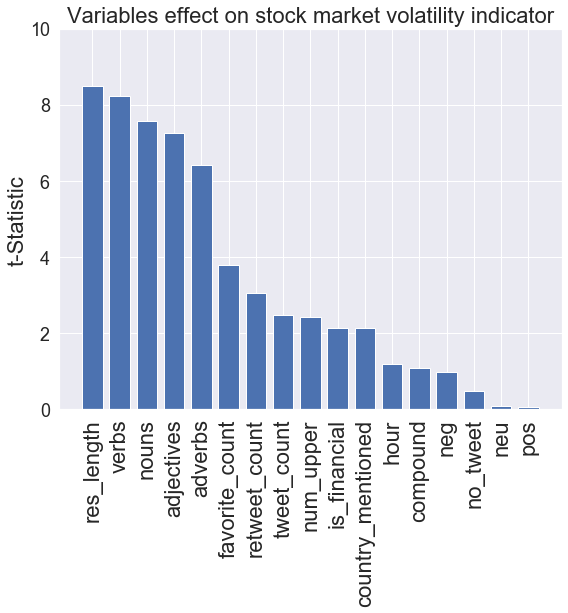

In [544]:
plt.figure(figsize=(30, 15)) #figure size
N=len(list(t_stat))

#coefficient variables
bar = sig_variables.loc[:, ['t-Statistic']].values.flatten()


#coefficient magnitudes
#bars = np.add(neg_bar, pos_bar).tolist()

ind = np.arange(N)    # the x locations for the groups
width = 0.75       # the width of the bars

#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,12), sharex=True)
fig, (ax2) = plt.subplots(1, 1, figsize=(9,7), sharex=True)
#ax1.bar(ind, bar, width, color='b',edgecolor='white')
#ax1.set_xlabel('')
#ax1.set_ylim(ymin=150)
ax2.bar(ind, bar, width, color='b',edgecolor='white')
ax2.set_title('')
ax2.set_ylim(ymax=10)
fig.text(0.06, 0.5, 't-Statistic', ha='center', va='center', rotation='vertical', fontsize=22)
ax2.set_title('Variables effect on stock market volatility indicator', fontsize=22)
plt.xticks(ind, list(t_stat), rotation='vertical', fontsize=22)
plt.yticks(fontsize=18)
#fig.subplots_adjust(top=-1)
plt.show()

In [45]:
list(X_train)

['retweet_count',
 'favorite_count',
 'hour',
 'neg',
 'neu',
 'pos',
 'num_upper',
 'is_financial',
 'country_mentioned',
 'nouns',
 'verbs',
 'adverbs',
 'adjectives',
 'tweet_count',
 'no_tweet',
 'res_length']

## Fit Classification Models

## KNN model

In [98]:
#Normalize data for KNN model
scaler = MinMaxScaler() #scale to 0-1 range
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_norm = pd.DataFrame(scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns)


#Determine KNN model K
for k in [1,2,3,4,5,7,9,10,15,25, 50, 75, 100]:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_norm, y_train)

    cross_validation_scores_KNN = cross_val_score(knn_model, X_train_norm, y_train.values.flatten(), cv=5)

    #estimating the CV accuracy and stdev of the model
    print("k =", k, "; Accuracy: %0.2f (+/- %0.2f)" % (cross_validation_scores_KNN.mean(), cross_validation_scores_KNN.std()))


k = 1 ; Accuracy: 0.57 (+/- 0.02)
k = 2 ; Accuracy: 0.55 (+/- 0.02)
k = 3 ; Accuracy: 0.58 (+/- 0.05)
k = 4 ; Accuracy: 0.56 (+/- 0.02)
k = 5 ; Accuracy: 0.59 (+/- 0.04)
k = 7 ; Accuracy: 0.61 (+/- 0.04)
k = 9 ; Accuracy: 0.61 (+/- 0.05)
k = 10 ; Accuracy: 0.62 (+/- 0.03)
k = 15 ; Accuracy: 0.63 (+/- 0.04)
k = 25 ; Accuracy: 0.65 (+/- 0.03)
k = 50 ; Accuracy: 0.65 (+/- 0.04)
k = 75 ; Accuracy: 0.66 (+/- 0.03)
k = 100 ; Accuracy: 0.66 (+/- 0.04)


In [146]:
# your code here
knn_model = KNeighborsClassifier(n_neighbors=75)
knn_model.fit(X_train_norm, y_train)

#Accuracy score calcualtion for test set prediction
KNN_test_predict = knn_model.predict(X_test_norm.values)
print('\nAccuracy score of KNN model at K=50 (test set):\n\n', accuracy_score(y_test, KNN_test_predict))

acc_knn = accuracy_score(y_test, KNN_test_predict)


Accuracy score of KNN model at K=50 (test set):

 0.645


In [111]:
cm_knn = metrics.confusion_matrix(y_test, knn_model.predict(X_test_norm.values))
print("Confusion matrix of KNN model predictions using the test dataset: \n\n", cm_knn)
print("\nThe KNN model at K=50 yielded N false positives, and N false negatives.")
TPR_knn = cm_knn[0, 0]/(cm_knn[0, 0]+cm_knn[1, 0])
TNR_knn = cm_knn[1, 1]/(cm_knn[1, 1]+cm_knn[0, 1])

Confusion matrix of KNN model predictions using the test dataset: 

 [[52 48]
 [23 77]]

The KNN model at K=50 yielded N false positives, and N false negatives.


0.616

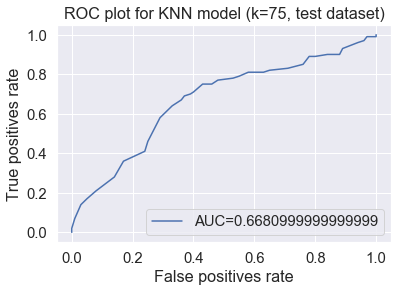

In [384]:
fpr, tpr, _ = metrics.roc_curve(y_test.values, knn_model.predict_proba(X_test_norm.values).T[1])
auc = metrics.roc_auc_score(y_test.values, knn_model.predict_proba(X_test_norm.values).T[1])
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel("False positives rate")
plt.ylabel("True positives rate")
plt.title("ROC plot for KNN model (k=75, test dataset)")
plt.show()
auc_knn = auc

### Fit logistic model with lasso regularizaton

In [508]:
#fit logistic model with lasso regularization and 10-fold cross-validation
logreg_m_lasso = LogisticRegressionCV(cv=10, penalty = "l1", solver = 'liblinear') #10-fold cross-validation
logreg_m_lasso = logreg_m_lasso.fit(X_train_norm.values, y_train)

#Accuracy score calcualtion for test set prediction
lgm_test_predict = logreg_m_lasso.predict(X_test_norm.values)
print('\nAccuracy score of multiple logistic model with lasso regularization and 10-fold cross-validation (test set):\n\n', accuracy_score(y_test, lgm_test_predict))

#Accuracy score calcualtion for train set prediction
lgm_train_predict = logreg_m_lasso.predict(X_train_norm.values)
print('\nAccuracy score of multiple logistic model with lasso regularization and 10-fold cross-validation (train set):\n\n', accuracy_score(y_train, lgm_train_predict))

acc_logistic = accuracy_score(y_test, lgm_test_predict)

C:\Users\Yoyo\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yoyo\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Accuracy score of multiple logistic model with lasso regularization and 10-fold cross-validation (test set):

 0.625

Accuracy score of multiple logistic model with lasso regularization and 10-fold cross-validation (train set):

 0.6595744680851063


In [112]:
cm_logistic = metrics.confusion_matrix(y_test, logreg_m_lasso.predict(X_test_norm.values))
print("Confusion matrix of logistic model with lasso regularization using the test dataset: \n\n", cm_logistic)
print("\nThe of logistic model with lasso regularization yielded N false positives, and N false negatives.")
TPR_logistic = cm_logistic[0, 0]/(cm_logistic[0, 0]+cm_logistic[1, 0])
TNR_logistic = cm_logistic[1, 1]/(cm_logistic[1, 1]+cm_logistic[0, 1])

Confusion matrix of logistic model with lasso regularization using the test dataset: 

 [[51 49]
 [26 74]]

The of logistic model with lasso regularization yielded N false positives, and N false negatives.


### Plot ROC curve and calcualte AUC for logistic model

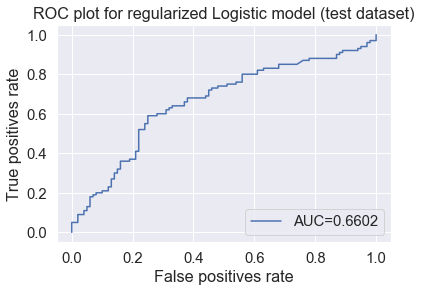

In [540]:
fpr, tpr, _ = metrics.roc_curve(y_test.values, logreg_m_lasso.predict_proba(X_test_norm.values).T[1])
auc = metrics.roc_auc_score(y_test.values, logreg_m_lasso.predict_proba(X_test_norm.values).T[1])
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel("False positives rate")
plt.ylabel("True positives rate")
plt.title("ROC plot for regularized Logistic model (test dataset)")
plt.show()
auc_logistic = auc

### Fit decision tree classifier

In [541]:
def calc_meanstd(X_train, y_train, depths):
    '''
    
    Calculates variation in model accuracy with tree depth
    Plots train and test dataset accuracy as a function of tree depth
    
    Receives: predictors 2d array, response variable array, and the maximum tree depth.
    
    '''
    
    #Initialize variables
    train_scores = {} # dictionary of cv scores for train dataset
    cvmeans = {} # avarage CV scores - test dataset
    cvstds = {} # standard errors of CV scores - test dataset
    train_means = {} # avarage CV scores - train dataset
    train_std = {} # standard errors of CV scores - train dataset
    
    #Calculate cumulative accuracies 
    for depth in depths:
        dt = DecisionTreeClassifier(max_depth = depth)
        dt.fit(X_train, y_train)
        CV_scores = cross_val_score(dt, X_test, y_test, cv=15)
        train_CV = cross_val_score(dt, X_train, y_train, cv=15)
        train_scores[depth] = train_CV
        train_means[depth] = train_CV.mean()
        train_std[depth] = train_CV.std()
        cvmeans[depth] = CV_scores.mean()
        cvstds[depth] = CV_scores.std()
        
    #plot variables    
    x = list(cvmeans.keys()) # x-axis
    y = list(cvmeans.values()) # accuracies based on test dataset
    y_train = list(train_means.values()) # accuracies based on train dataset
    e = list(cvstds.values()) #error bars
    e_train = list(train_std.values()) #error bars
    lists = sorted(cvmeans.items())
    x, y = zip(*lists) 
    
    #plot
    plt.ylabel("Cross Validation Accuracy")
    plt.xlabel("Maximum Depth")
    plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
    plt.plot(x, y, marker='o', label = 'test set', color='C0')
    plt.plot(x, y_train, marker='o', label = 'train set', color='C3')
    plt.errorbar(x, y, e, fmt='-o', capsize=5, elinewidth=2, markeredgewidth=2, color='C0')
    plt.errorbar(x, y_train, e_train, fmt='-o', capsize=5, elinewidth=2, markeredgewidth=2, color='C3')
    plt.legend()
    plt.show()
    # end of your code here
    return 

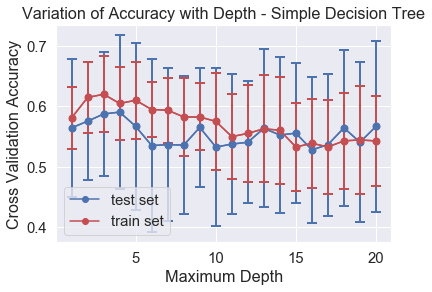

In [542]:


depths = list(range(1, 21)) # tree depths to test
calc_meanstd(X_train, y_train, depths)

In [290]:
dt = DecisionTreeClassifier(max_depth = 3)
dt.fit(X_train, y_train)
CV_scores = cross_val_score(dt, X_test, y_test, cv=5)

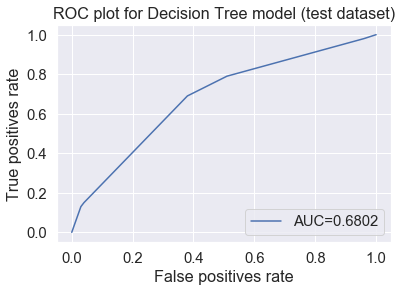

In [382]:
fpr, tpr, _ = metrics.roc_curve(y_test.values, dt.predict_proba(X_test.values).T[1])
auc = metrics.roc_auc_score(y_test.values, dt.predict_proba(X_test.values).T[1])
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel("False positives rate")
plt.ylabel("True positives rate")
plt.title("ROC plot for Decision Tree model (test dataset)")
plt.show()
auc_dt = auc

In [292]:
#Accuracy score calcualtion for test set prediction
dt_test_predict = dt.predict(X_test.values)
print('\nAccuracy score of decision tree classfier (test set):\n\n', accuracy_score(y_test, dt_test_predict))

#Accuracy score calcualtion for train set prediction
dt_train_predict = dt.predict(X_train.values)
print('\nAccuracy score of decision tree classfier (train set):\n\n', accuracy_score(y_train, dt_train_predict))

acc_dt = dt.score(X_test, y_test)


Accuracy score of decision tree classfier (test set):

 0.655

Accuracy score of decision tree classfier (train set):

 0.6683354192740926


In [293]:
cm_dt = metrics.confusion_matrix(y_test, dt.predict(X_test.values))
print("Confusion matrix of logistic model with decision tree classfier using the test dataset: \n\n", cm_dt)
print("\nThe of decision tree classfier yielded N false positives, and N false negatives.")
TPR_dt = cm_dt[0, 0]/(cm_dt[0, 0]+cm_dt[1, 0])
TNR_dt = cm_dt[1, 1]/(cm_dt[1, 1]+cm_dt[0, 1])

Confusion matrix of logistic model with decision tree classfier using the test dataset: 

 [[62 38]
 [31 69]]

The of decision tree classfier yielded N false positives, and N false negatives.


#### Model feature importance

Feature ranking:
1. feature 15 (0.512903)
2. feature 2 (0.142624)
3. feature 10 (0.113980)
4. feature 4 (0.081640)
5. feature 9 (0.076154)
6. feature 0 (0.072699)
7. feature 14 (0.000000)
8. feature 13 (0.000000)
9. feature 12 (0.000000)
10. feature 11 (0.000000)
11. feature 8 (0.000000)
12. feature 7 (0.000000)
13. feature 6 (0.000000)
14. feature 5 (0.000000)
15. feature 3 (0.000000)
16. feature 1 (0.000000)


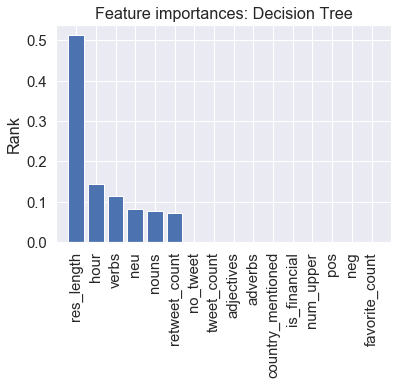

In [387]:
#Decision tree feature importance
importances = dt.feature_importances_
#std = np.std([tree.feature_importances_ for tree in dt.estimators_],
#            axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances: Decision Tree")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(X_train.shape[1]), list(X_train.iloc[:, indices]), rotation='vertical')
plt.ylabel("Rank")
plt.xlim([-1, X_train.shape[1]])
plt.show()



In [ ]:
f = tweets.groupby(['Date']).count().reset_index()
d = (f.Date >= datetime.date(year=2016,month=11,day=1))
#display(f)
plt.figure(figsize=(18,10))
#plt.scatter(f['Date'], f['is_retweet'])
x = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['Date']
y1 = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['moving_avg']
y2 = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['Adj Close']  
plt.plot(x, preprocessing.scale(y2), marker = 'o' , label = 'Adj Close', color='green', alpha=0.5)
plt.plot(f[d].Date, preprocessing.scale(f[d].is_retweet), marker = 'o' , label = 'Adj Close', color='grey', alpha=0.5)
plt.plot(f[d].Date, preprocessing.scale(f[d].adjectives), marker = 'o' , label = 'Adj Close', color='orange', alpha=0.5)

#sns.scatterplot(x='Date', y='is_retweet', data=preprocessing.scale(f[d].is_retweet))
plt.ylabel("Tweets per Day", fontsize=24)
plt.xlabel("Date", fontsize=24)
plt.title("Tweets per Day Over Time", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

datamerge = datamerge.drop(['DateEST'], axis=1)

In [ ]:
f = tweets.groupby(['Date']).count().reset_index()
d = (f.Date >= datetime.date(year=2016,month=11,day=1))
#display(f)
plt.figure(figsize=(18,10))
#plt.scatter(f['Date'], f['is_retweet'])
x = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['Date']
y1 = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['moving_avg']
y2 = CBOE[CBOE['Date']>datetime.date(2016, 11, 1)]['Adj Close']  
plt.plot(x, preprocessing.scale(y2), marker = 'o' , label = 'Adj Close', color='green', alpha=0.5)
plt.plot(f[d].Date, preprocessing.scale(f[d].is_retweet), marker = 'o' , label = 'Adj Close', color='grey', alpha=0.5)
plt.plot(f[d].Date, preprocessing.scale(f[d].adjectives), marker = 'o' , label = 'Adj Close', color='orange', alpha=0.5)

#sns.scatterplot(x='Date', y='is_retweet', data=preprocessing.scale(f[d].is_retweet))
plt.ylabel("Tweets per Day", fontsize=24)
plt.xlabel("Date", fontsize=24)
plt.title("Tweets per Day Over Time", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

datamerge = datamerge.drop(['DateEST'], axis=1)

## Fit random forest classifier

#### Determination of optimal decision tree classifier depth

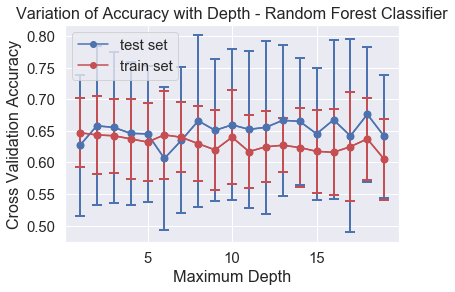

In [539]:
def calc_meanstd(X_train, y_train, depths):
    '''
    
    Calculates variation in model accuracy with tree depth
    Plots train and test dataset accuracy as a function of tree depth
    
    Receives: predictors 2d array, response variable array, and the maximum tree depth.
    
    '''
    
    #Initialize variables
    train_scores = {} # dictionary of cv scores for train dataset
    cvmeans = {} # avarage CV scores - test dataset
    cvstds = {} # standard errors of CV scores - test dataset
    train_means = {} # avarage CV scores - train dataset
    train_std = {} # standard errors of CV scores - train dataset
    
    #Calculate cumulative accuracies 
    for depth in depths:
        dt = RandomForestClassifier(n_estimators = 145, max_depth=depth, max_features=1+round(sqrt(len(list(X_train)))))
        dt.fit(X_train, y_train)
        CV_scores = cross_val_score(dt, X_test, y_test, cv=15)
        train_CV = cross_val_score(dt, X_train, y_train, cv=15)
        train_scores[depth] = train_CV
        train_means[depth] = train_CV.mean()
        train_std[depth] = train_CV.std()
        cvmeans[depth] = CV_scores.mean()
        cvstds[depth] = CV_scores.std()
        
    #plot variables    
    x = list(cvmeans.keys()) # x-axis
    y = list(cvmeans.values()) # accuracies based on test dataset
    y_train = list(train_means.values()) # accuracies based on train dataset
    e = list(cvstds.values()) #error bars
    e_train = list(train_std.values()) #error bars
    lists = sorted(cvmeans.items())
    x, y = zip(*lists) 
    
    #plot
    plt.ylabel("Cross Validation Accuracy")
    plt.xlabel("Maximum Depth")
    plt.title('Variation of Accuracy with Depth - Random Forest Classifier')
    plt.plot(x, y, marker='o', label = 'test set', color='C0')
    plt.plot(x, y_train, marker='o', label = 'train set', color='C3')
    plt.errorbar(x, y, e, fmt='-o', capsize=5, elinewidth=2, markeredgewidth=2, color='C0')
    plt.errorbar(x, y_train, e_train, fmt='-o', capsize=5, elinewidth=2, markeredgewidth=2, color='C3')
    plt.legend()
    plt.show()
    # end of your code here
    return 

depths = list(range(1, 20)) # tree depths to test
calc_meanstd(X_train, y_train, depths)

#### Fit the model

In [538]:
from math import sqrt

np.random.seed(0)

forest = RandomForestClassifier(n_estimators = 145, max_depth = 12, max_features=1+round(sqrt(len(list(X_train)))))
forest.fit(X_train, y_train)

random_forest_test_score = accuracy_score(y_test, forest.predict(X_test.values))
print('\nAccuracy score of random forest model with 12 splits and 1+sqrt(N) features selected at each split (test set): \n', random_forest_test_score)

random_forest_train_score = accuracy_score(y_train, forest.predict(X_train.values))
print('\nAccuracy score of random forest model with 12 splits and 1+sqrt(N) features selected at each split (train set): \n', random_forest_train_score)

acc_forest = forest.score(X_test, y_test)


Accuracy score of random forest model with 12 splits and 1+sqrt(N) features selected at each split (test set): 
 0.68

Accuracy score of random forest model with 12 splits and 1+sqrt(N) features selected at each split (train set): 
 0.9924906132665833


In [234]:
cm_forest = metrics.confusion_matrix(y_test, forest.predict(X_test.values))
print("Confusion matrix of random forest model using the test dataset: \n\n", cm_forest)
print("\nThe of decision tree classfier yielded 26 false negatives, and 32 false positives.")
TPR_forest = cm_forest[0, 0]/(cm_forest[0, 0]+cm_forest[1, 0])
TNR_forest = cm_forest[1, 1]/(cm_forest[1, 1]+cm_forest[0, 1])

Confusion matrix of random forest model using the test dataset: 

 [[69 31]
 [33 67]]

The of decision tree classfier yielded 26 false negatives, and 32 false positives.


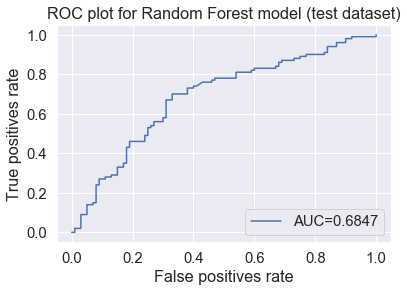

In [550]:
fpr, tpr, _ = metrics.roc_curve(y_test.values, forest.predict_proba(X_test.values).T[1])
auc = metrics.roc_auc_score(y_test.values, forest.predict_proba(X_test.values).T[1])
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel("False positives rate")
plt.ylabel("True positives rate")
plt.title("ROC plot for Random Forest model (test dataset)")
plt.show()
auc_forest = auc

In [196]:
#change classification threshold by ROC curve
predict_probabilities = forest.predict_proba(X_test)
predict_mine = np.where(predict_probabilities[:,1] > 0.5, 1, 0)
confusion_matrix(y_test, predict_mine)

array([[69, 31],
       [33, 67]], dtype=int64)

#### Model feature importance

Feature ranking:
1. feature 9 (0.101684)
2. feature 10 (0.096159)
3. feature 15 (0.092949)
4. feature 12 (0.078014)
5. feature 2 (0.073748)
6. feature 4 (0.068919)
7. feature 5 (0.064404)
8. feature 0 (0.063193)
9. feature 3 (0.062921)
10. feature 11 (0.061992)
11. feature 1 (0.057607)
12. feature 6 (0.054340)
13. feature 13 (0.051179)
14. feature 7 (0.044436)
15. feature 8 (0.028148)
16. feature 14 (0.000306)


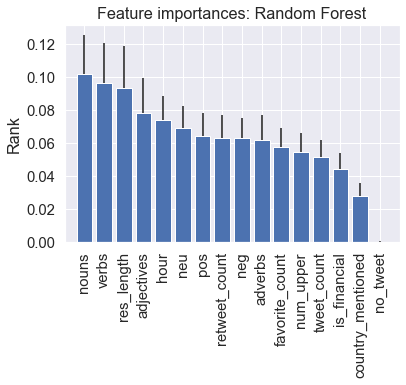

In [386]:
#Random Forest feature importance
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances: Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=[std[indices]/1000, std[indices]/2], align="center")
plt.xticks(range(X_train.shape[1]), list(X_train.iloc[:, indices]), rotation='vertical')
plt.ylabel("Rank")
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Fit AdaBoost classifier

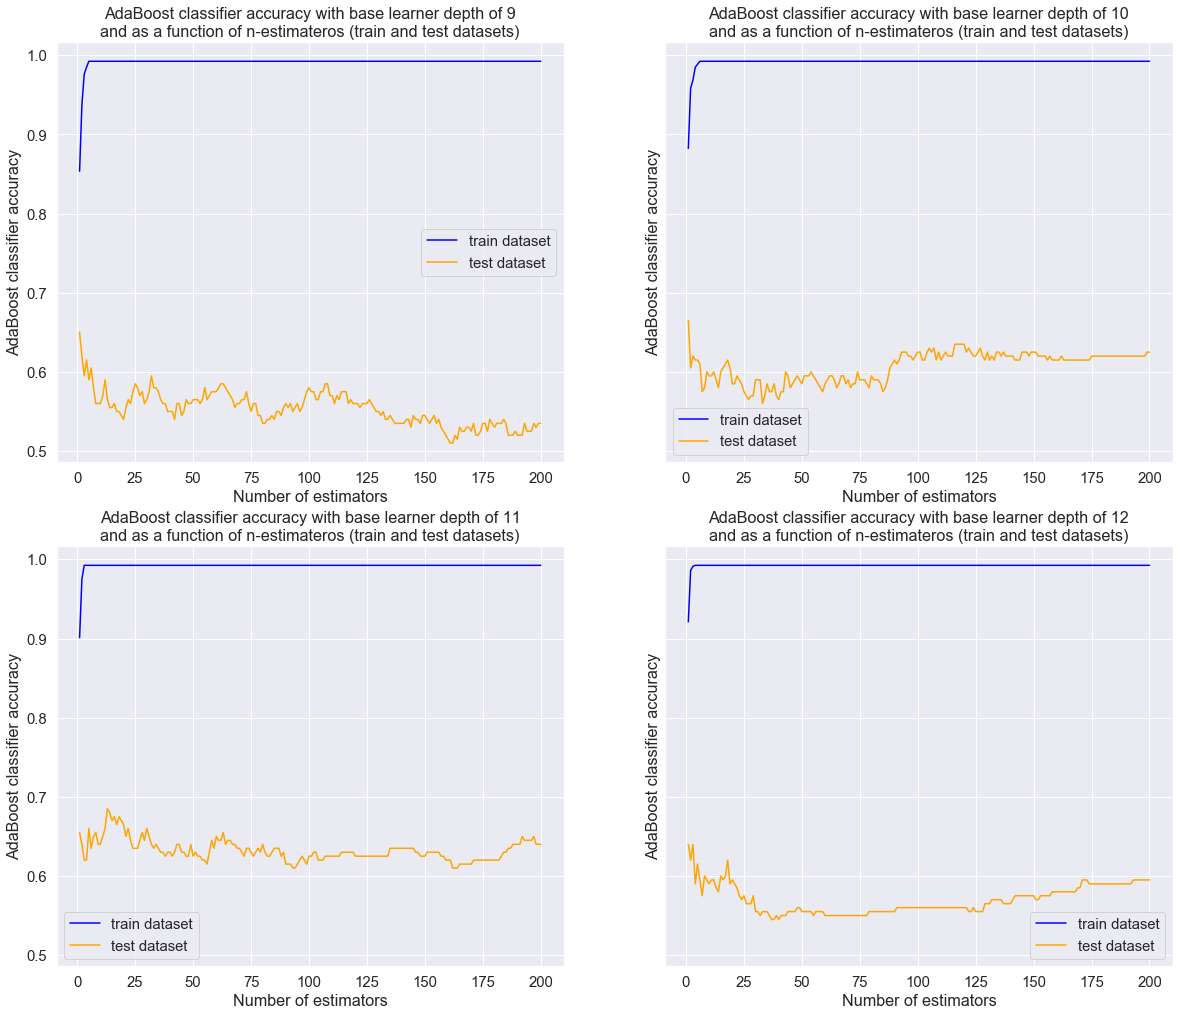

In [419]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,17), sharey=True)
for n, ax in enumerate(axs.ravel()):
    tree_n = DecisionTreeClassifier(max_depth=n+9)
    clf = AdaBoostClassifier(base_estimator=tree_n, n_estimators=200, random_state=10000, learning_rate=0.05)
    clf.fit(X_train, y_train) 

    #iterate over the n-esimators to generate accuracy score arrays for the charts
    train_scores = []
    test_scores = []
    for score in clf.staged_score(X_train, y_train, sample_weight=None): 
        train_scores.append(score) #append to scores array; ultimately y axis in the chart

    for score in clf.staged_score(X_test, y_test, sample_weight=None): 
        test_scores.append(score) #append to scores array; ultimately y axis in the chart

    #plot effect of the n-estimators/iterations on the model accuracy using train and test datasets
    ax.set_ylabel("AdaBoost classifier accuracy")
    ax.set_xlabel("Number of estimators")
    ax.set_title('AdaBoost classifier accuracy with base learner depth of '+str(n+9)+'\nand as a function of n-estimateros (train and test datasets)')
    ax.plot(np.arange(1, 201, 1), train_scores, marker='', label = 'train dataset', color='blue')
    ax.plot(np.arange(1, 201, 1), test_scores, marker='', label = 'test dataset', color='orange')
    ax.legend()
plt.show()

In [259]:
# your code here
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=11), n_estimators=18, random_state=10000, learning_rate=0.05)
clf.fit(X_train, y_train) 

print('\n\n Model accuracy at 18 interations and learning rate of 0.05 (test dataset):\n\n', clf.score(X_test, y_test))
print('\n\n Model accuracy at 18 interations and learning rate of 0.05 (train dataset):\n\n', clf.score(X_train, y_train))
acc_clf = clf.score(X_test, y_test)



 Model accuracy at 18 interations and learning rate of 0.05 (test dataset):

 0.675


 Model accuracy at 18 interations and learning rate of 0.05 (train dataset):

 0.9924906132665833


In [260]:
cm = metrics.confusion_matrix(y_test, clf.predict(X_test.values))
print("Confusion matrix of AdaBoost model predictions using the test dataset: \n\n", cm)
print("\nThe random AdaBoost model yielded N false positives, and N false negatives.")
TPR_clf = cm[0, 0]/(cm[0, 0]+cm[1, 0])
TNR_clf = cm[1, 1]/(cm[1, 1]+cm[0, 1])

Confusion matrix of AdaBoost model predictions using the test dataset: 

 [[69 31]
 [34 66]]

The random AdaBoost model yielded N false positives, and N false negatives.


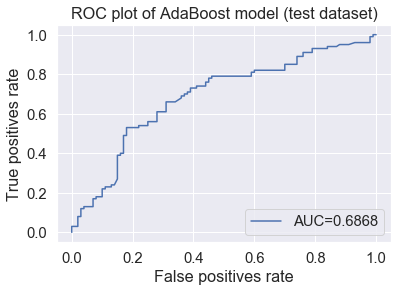

In [261]:
fpr, tpr, _ = metrics.roc_curve(y_test.values, clf.predict_proba(X_test.values).T[1])
auc = metrics.roc_auc_score(y_test.values, clf.predict_proba(X_test.values).T[1])
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel("False positives rate")
plt.ylabel("True positives rate")
plt.title("ROC plot of AdaBoost model (test dataset)")
plt.show()
auc_clf = auc

#### Model feature importance

Feature ranking:
1. feature 2 (0.206745)
2. feature 3 (0.202626)
3. feature 12 (0.169310)
4. feature 15 (0.099719)
5. feature 4 (0.064997)
6. feature 10 (0.036086)
7. feature 11 (0.032300)
8. feature 5 (0.028962)
9. feature 6 (0.028091)
10. feature 0 (0.026789)
11. feature 9 (0.026025)
12. feature 13 (0.023209)
13. feature 1 (0.019111)
14. feature 8 (0.018921)
15. feature 7 (0.017066)
16. feature 14 (0.000043)


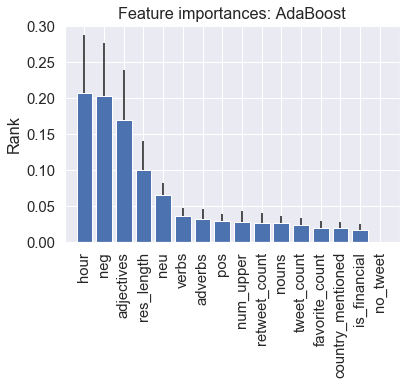

In [388]:
#AdaBoost feature importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances: AdaBoost")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=[std[indices]/1000, std[indices]/2], align="center")
plt.xticks(range(X_train.shape[1]), list(X_train.iloc[:, indices]), rotation='vertical')
plt.ylabel("Rank")
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Fit random forest regressor 
#### Prediction of daily S&P500 daily fluctuation range

In [509]:
datamerge_reg = datamerge.copy()
datamerge_reg['change'] = datamerge_reg['daily_change_low_high']
datamerge_reg = datamerge_reg.dropna()
#Split to train and test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg =train_test_split(datamerge_reg.loc[:, list(datamerge_reg.drop(['compound','Adj Close', 'moving_avg', 'daily_change_low', 'daily_change_high', 'daily_change_low_high','daily_change_close', 'Date', 'moving_avg', 'change'], axis=1))], 
                                                         datamerge_reg.daily_change_low_high, test_size=0.2, 
                                                         random_state = 109,  stratify = datamerge.change)


In [510]:
X_train_reg.shape

(799, 16)

### Normalize variables data

In [511]:
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer

#transform response variable
y_test_reg_tr= power_transform(y_test_reg.values.reshape(-1,1), method='yeo-johnson', standardize=False).reshape(1,-1)[0] 
y_train_reg_tr= power_transform(y_train_reg.values.reshape(-1,1), method='yeo-johnson', standardize=False).reshape(1,-1)[0] 

from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit(X_train_reg)
pt.fit(X_test_reg)
X_train_reg_tr = pt.transform(X_train_reg)
X_test_reg_tr = pt.transform(X_test_reg)

In [512]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


forest_reg = RandomForestRegressor(n_estimators = 150, max_depth=4, max_features=round(sqrt(len(list(X_train)))))
forest_reg.fit(X_train_reg_tr, y_train_reg_tr)
print('R-squared: \n\n', r2_score(y_test_reg_tr, forest_reg.predict(X_test_reg_tr)))
print('\n\nRMSE: \n\n', mean_squared_error(y_test_reg_tr, forest_reg.predict(X_test_reg_tr)))

R-squared: 

 0.16857387659458611


RMSE: 

 0.005669872999686513


In [513]:
datamerge_reg['change'].mean()

0.8591892339871254

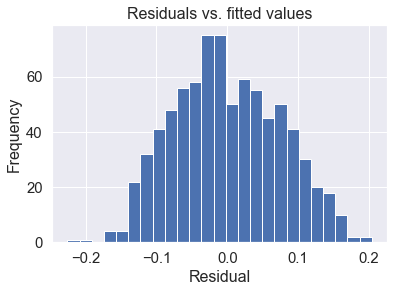

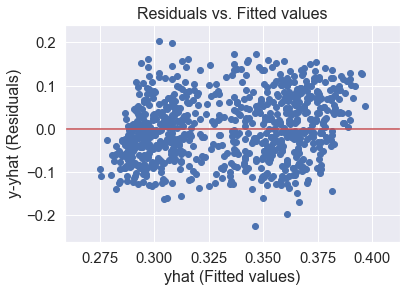

In [514]:
#plots histogram of residuals:
sns.set(font_scale=1.35)
from scipy import stats

fig, ax = plt.subplots()

resid = y_train_reg_tr - forest_reg.predict(X_train_reg_tr)
ax.hist(resid, bins=25)
ax.set_title('Histogram of random forest regressor residuals',fontsize=16);
ax.set_title('Residuals vs. fitted values',fontsize=16)
ax.set_ylabel('Frequency',fontsize=16)
ax.set_xlabel('Residual',fontsize=16);

plt.show()

y = y_train_reg_tr
yhat = forest_reg.predict(X_train_reg_tr)

fig, ax = plt.subplots()
ax.scatter(yhat, y-yhat)
line_fit = yhat
plt.axhline(y=0.0, color='r', linestyle='-')

ax.set_title('Residuals vs. Fitted values',fontsize=16)
ax.set_ylabel('y-yhat (Residuals)',fontsize=16)
ax.set_xlabel('yhat (Fitted values)',fontsize=16);
plt.show()

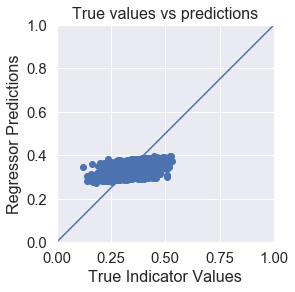

In [547]:
test_predictions = forest_reg.predict(X_train_reg_tr).flatten()

a = plt.axes(aspect='equal')
plt.title('True values vs predictions',fontsize=16)
plt.scatter(y_train_reg_tr, test_predictions)
plt.xlabel('True Indicator Values')
plt.ylabel('Regressor Predictions')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Feature ranking:
1. feature 9 (0.195572)
2. feature 15 (0.158221)
3. feature 10 (0.143703)
4. feature 12 (0.103107)
5. feature 11 (0.062786)
6. feature 0 (0.044886)
7. feature 2 (0.044204)
8. feature 5 (0.041329)
9. feature 1 (0.039278)
10. feature 6 (0.033268)
11. feature 4 (0.032424)
12. feature 3 (0.030122)
13. feature 7 (0.029206)
14. feature 13 (0.029117)
15. feature 8 (0.012776)
16. feature 14 (0.000001)


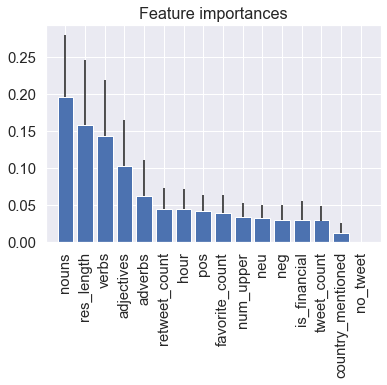

In [516]:
#Random forest regressor feature importance
importances = forest_reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=[std[indices]/1000, std[indices]/2], align="center")
plt.xticks(range(X_train.shape[1]), list(X_train.iloc[:, indices]), rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [517]:
X_train_reg_tr.shape

(799, 16)

## Neural Net classifier

Model: "fully_connected_neural_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 150)               2550      
_________________________________________________________________
dropout_53 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_236 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_237 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_238 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_239 (Dense)            (None, 1)                 151       
Total params: 70,651
Trainable params: 70,651
Non-trainable params: 0
________________________________

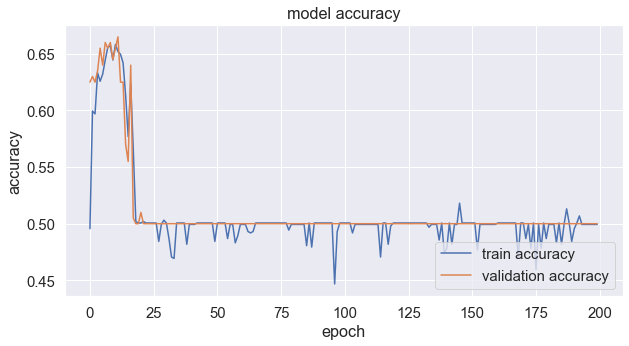

In [519]:
#Optimized model
from sklearn import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

model = tf.keras.models.Sequential(name='fully_connected_neural_network')
count = 0 #counte for chart plotting 

# 3 hidden layers with dropout and regularization setting
model.add(layers.Dense(150, activation='relu', input_shape=(16,), 
                                kernel_regularizer= tf.keras.regularizers.l2(l=0.05)))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(150, activation='relu', 
                                kernel_regularizer= tf.keras.regularizers.l2(l=0.05)))
#model.add(layers.Dropout(0.2))

model.add(layers.Dense(150, activation='relu', 
                                kernel_regularizer= tf.keras.regularizers.l2(l=0.05)))
#model.add(layers.Dropout(0.2))

model.add(layers.Dense(150, activation='relu', 
                                kernel_regularizer= tf.keras.regularizers.l2(l=0.05)))



# output layer
model.add(layers.Dense(1,  activation='sigmoid'))

model.compile(optimizer='adam',
                loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

#Fit model using scaled data
model_fit = model.fit(preprocessing.scale(X_train.values), y_train.values, validation_data=(preprocessing.scale(X_test.values), y_test.values), epochs=200, batch_size=128, verbose=0)


#Calcualte model accuracy
train_loss, train_acc = model.evaluate(preprocessing.scale(X_train.values), y_train.values, verbose=0)
#print("Model train accuracy: ", model_fit.history['accuracy'][len(model_fit.history['accuracy'])-1])
#print("Model validation accuracy: ", model_fit.history['val_accuracy'][len(model_fit.history['accuracy'])-1])

# summarize history for model accuracy
plt.figure(figsize=(10, 5))
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

#### Refit neural net model using 10 epoch and batch of 128

In [390]:
model = tf.keras.models.Sequential(name='fully_connected_neural_network')
count = 0 #counte for chart plotting 

# 3 hidden layers with dropout and regularization setting
model.add(layers.Dense(150, activation='relu', input_shape=(16,), 
                                kernel_regularizer= tf.keras.regularizers.l2(l=0.05)))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(150, activation='relu', 
                                kernel_regularizer= tf.keras.regularizers.l2(l=0.05)))
#model.add(layers.Dropout(0.2))

model.add(layers.Dense(150, activation='relu', 
                                kernel_regularizer= tf.keras.regularizers.l2(l=0.05)))
#model.add(layers.Dropout(0.2))

model.add(layers.Dense(150, activation='relu', 
                                kernel_regularizer= tf.keras.regularizers.l2(l=0.05)))



# output layer
model.add(layers.Dense(1,  activation='sigmoid'))

model.compile(optimizer='adam',
                loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

#Fit model using scaled data
model_fit = model.fit(preprocessing.scale(X_train.values), y_train.values, validation_data=(preprocessing.scale(X_test.values), y_test.values), epochs=10, batch_size=128, verbose=0)


Model: "fully_connected_neural_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_142 (Dense)            (None, 150)               2550      
_________________________________________________________________
dropout_33 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_144 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_145 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 151       
Total params: 70,651
Trainable params: 70,651
Non-trainable params: 0
________________________________

Neural Net model train accuracy:  0.64580727
Neural Neet model validation accuracy:  0.65

Confusion matrix of AdaBoost model predictions using the test dataset: 

 [[69 31]
 [39 61]]

Neural net classifier yielded N false positives, and N false negatives.


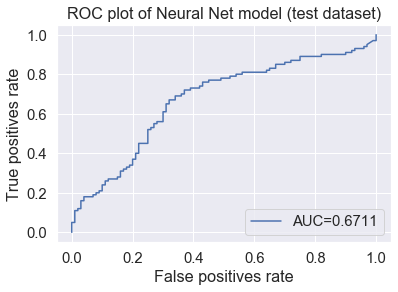

In [391]:
# your code here
print("Neural Net model train accuracy: ", model_fit.history['accuracy'][len(model_fit.history['accuracy'])-1])
print("Neural Neet model validation accuracy: ", model_fit.history['val_accuracy'][len(model_fit.history['accuracy'])-1])
acc_nn = model_fit.history['val_accuracy'][len(model_fit.history['accuracy'])-1]


cm = metrics.confusion_matrix(y_test.values, model.predict_classes(preprocessing.scale(X_test.values)))
print("\nConfusion matrix of AdaBoost model predictions using the test dataset: \n\n", cm)
print("\nNeural net classifier yielded N false positives, and N false negatives.")
TPR_nn = cm[0, 0]/(cm[0, 0]+cm[1, 0])
TNR_nn = cm[1, 1]/(cm[1, 1]+cm[0, 1])

fpr, tpr, _ = metrics.roc_curve(y_test.values, model.predict(preprocessing.scale(X_test.values)))
auc = metrics.roc_auc_score(y_test.values, model.predict(preprocessing.scale(X_test.values)))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel("False positives rate")
plt.ylabel("True positives rate")
plt.title("ROC plot of Neural Net model (test dataset)")
plt.show()
auc_nn = auc


## Neural Net Regressor
#### Create standardized features for neural net regressor using preprocessing.scale()

In [484]:
#Optimized model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers


model = tf.keras.models.Sequential(name='fully_connected_neural_network')

# 4 hidden layers with dropout and regularization setting
model.add(layers.Dense(150, activation='relu', input_shape=(16,), 
                                kernel_regularizer= tf.keras.regularizers.l2(l=0.05)))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(150, activation='relu', 
                                kernel_regularizer= tf.keras.regularizers.l2(l=0.05)))
#model.add(layers.Dropout(0.2))

model.add(layers.Dense(150, activation='relu', 
                                kernel_regularizer= tf.keras.regularizers.l2(l=0.05)))

model.add(layers.Dense(150, activation='relu', 
                                kernel_regularizer= tf.keras.regularizers.l2(l=0.05)))

# output layer
model.add(layers.Dense(1,  activation='linear'))



model.compile(optimizer='Adam',
                  loss=['mse'],
                  metrics=['mse'])

model.optimizer.learningRate = 1

model.summary()

model_fit = model.fit(preprocessing.scale(X_train_reg_tr), y_train_reg_tr, validation_data=(preprocessing.scale(X_test_reg_tr), y_test_reg_tr), epochs=300, batch_size=128, verbose=0)




Model: "fully_connected_neural_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_225 (Dense)            (None, 150)               2550      
_________________________________________________________________
dropout_51 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_226 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_227 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_228 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_229 (Dense)            (None, 1)                 151       
Total params: 70,651
Trainable params: 70,651
Non-trainable params: 0
________________________________


Epoch: 0, loss:0.0076,  mse:0.0076,  val_loss:0.0074,  val_mse:0.0074,  
....................................................................................................
Epoch: 100, loss:0.0077,  mse:0.0077,  val_loss:0.0076,  val_mse:0.0076,  
....................................................................................................

Text(0, 0.5, 'MSE [Volatility Indicator]')

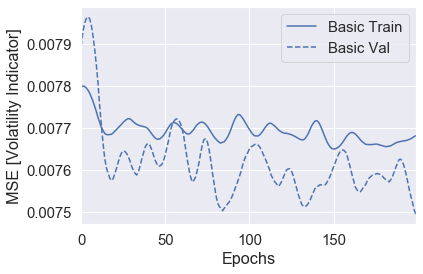

In [478]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras import layers

EPOCHS = 200

history = model.fit(
  preprocessing.scale(X_train_reg_tr), y_train_reg_tr,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])



hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)


plotter.plot({'Basic': history}, metric = "mse")
#plt.ylim([0, 20])
plt.ylabel('MSE [Volatility Indicator]')


In [485]:
loss, mse = model.evaluate(preprocessing.scale(X_train_reg_tr), y_train_reg_tr, verbose=2)

print("Testing MSE: {:5.5f} index".format(mse))


799/1 - 0s - loss: 0.0070 - mse: 0.0076
Testing MSE: 0.00762 index


In [490]:
print('R-squared: \n\n', r2_score(y_test_reg_tr, model.predict(preprocessing.scale(X_test_reg_tr))))
print('\n\nRMSE: \n\n', mean_squared_error(y_test_reg_tr, model.predict(preprocessing.scale(X_test_reg_tr))))

R-squared: 

 -0.0066767957888778096


RMSE: 

 0.008025926757142062


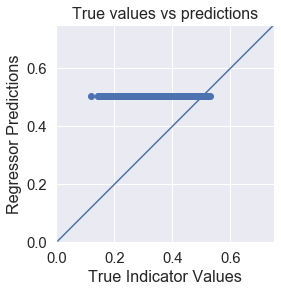

In [549]:
test_predictions = model.predict(preprocessing.scale(X_train_reg_tr)).flatten()

a = plt.axes(aspect='equal')
plt.title('True values vs predictions',fontsize=16)
plt.scatter(y_train_reg_tr, test_predictions)
plt.xlabel('True Indicator Values')
plt.ylabel('Regressor Predictions')
lims = [0, 0.75]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


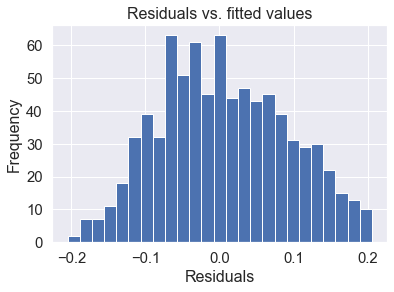

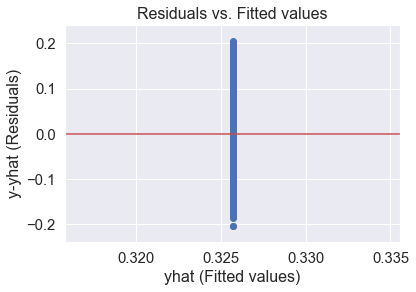

In [487]:
#plots histogram of residuals:
sns.set(font_scale=1.35)
from scipy import stats

fig, ax = plt.subplots()

resid = y_train_reg_tr - model.predict(preprocessing.scale(X_train_reg_tr)).reshape(1,-1)[0]
ax.hist(resid, bins=25)
ax.set_title('Histogram of neural net regressor residuals',fontsize=16);
ax.set_title('Residuals vs. fitted values',fontsize=16)
ax.set_ylabel('Frequency',fontsize=16)
ax.set_xlabel('Residuals',fontsize=16);

plt.show()

y = y_train_reg_tr
yhat = model.predict(preprocessing.scale(X_train_reg_tr)).reshape(1,-1)[0]

fig, ax = plt.subplots()
ax.scatter(yhat, y-yhat)
line_fit = yhat
plt.axhline(y=0.0, color='r', linestyle='-')

ax.set_title('Residuals vs. Fitted values',fontsize=16)
ax.set_ylabel('y-yhat (Residuals)',fontsize=16)
ax.set_xlabel('yhat (Fitted values)',fontsize=16);
plt.show()

## Summary of classification models metrics


In [380]:
pd.DataFrame({'Model': ['KNN', 'l2-Logistic', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Neural Net'], 
              'Acuracy Score': [acc_knn, acc_logistic, acc_dt, acc_forest, acc_clf, acc_nn], 
             'AUC': [auc_knn, auc_logistic, auc_dt, auc_forest, auc_clf, auc_nn],
             'TPR': [TPR_knn, TPR_logistic, TPR_dt, TPR_forest, TPR_clf, TPR_nn],
             'TNR': [TNR_knn, TNR_logistic, TNR_dt, TNR_forest, TNR_clf, TNR_nn]}
            ).round(3).sort_values(by='Acuracy Score')

,Model,Acuracy Score,AUC,TPR,TNR
1,l2-Logistic,0.625,0.661,0.662,0.602
0,KNN,0.645,0.668,0.693,0.616
5,Neural Net,0.650,0.672,0.670,0.634
2,Decision Tree,0.655,0.680,0.667,0.645
4,AdaBoost,0.675,0.687,0.670,0.680
3,Random Forest,0.680,0.685,0.676,0.684
